## Data Loading and Pre-processing

In [36]:
import pandas as pd
import numpy as np
# import pymc as pm
# import pytensor
from pytensor import scan
import pytensor.tensor as pt
from pathlib import Path
import ipywidgets
#from pymc.model.transform.optimization import freeze_dims_and_data
import numpy as np
from numpy.linalg import cholesky, solve
from numpy.random import default_rng
import matplotlib.pyplot as plt
from IPython.display import display


START_DATE = "1990-01-01"
STATE_CODES = ["NSW","VIC","QLD","SA","WA","TAS","NT","ACT"]
Q_END = [3,6,9,12]

RAW = Path("data/raw_mfbvar.csv")
if not RAW.exists():
    raise FileNotFoundError("raw_mfbvar.csv not found.")


raw = pd.read_csv(RAW, parse_dates=["date"])
raw = raw[raw["date"] >= START_DATE]

In [37]:
SCHEMA_PATH = "data/schema_mfbvar.csv"
RAW_PATH    = "data/raw_mfbvar.csv"

# Load files
schema = pd.read_csv(SCHEMA_PATH)

# Basic checks (only what exists in the schema)
for c in ["series_id","alias","freq","transform","geo","geo_name","series_title"]:
    if c not in schema.columns:
        raise ValueError(f"Schema missing required column: {c}")

# Build series_bank from RAW (long format)
def build_series_bank_long(raw_df: pd.DataFrame) -> dict:
    for col in ["series_id","date","value"]:
        if col not in raw_df.columns:
            raise ValueError(f"raw_mfbvar is missing required column '{col}'")
    series_bank = {}
    df = raw_df[["series_id","date","value"]].copy()
    df["series_id"] = df["series_id"].astype(str)
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    for sid, g in df.groupby("series_id"):
        s = pd.Series(g["value"].values, index=pd.to_datetime(g["date"].values))
        s = s.sort_index()
        series_bank[sid] = s
    return series_bank

series_bank = build_series_bank_long(raw)
ALIASES = schema.set_index("alias")

# Transform & resample helpers (exact to the  schema’s 'freq'/'transform')
def to_quarterly(s: pd.Series, how="mean") -> pd.Series:
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)
    return s.resample("QE").agg(how)

def safe_log(s: pd.Series) -> pd.Series:
    x = s.astype(float).copy()
    x[x <= 0] = np.nan
    return np.log(x)

def apply_transform(s: pd.Series, code: str) -> pd.Series:
    c = str(code).strip().lower()
    if c in ("", "level", "none", "identity"):
        return s
    if c == "log":
        return safe_log(s)
    if c in ("dlog1","qoq_logdiff"):
        return safe_log(s).diff()
    raise ValueError(f"Unsupported transform in schema: {code}")

def to_quarter_period(s: pd.Series) -> pd.Series:
    """Put a quarterly series on a PeriodIndex Q-JUN (ABS style) for clean alignment."""
    idx = pd.to_datetime(s.index)
    q = idx.to_period("Q-JUN")
    s2 = pd.Series(s.values, index=q)
    return s2.groupby(level=0).mean()

def load_q(alias: str) -> pd.Series:
    row = ALIASES.loc[alias]
    sid = str(row["series_id"])
    freq = str(row["freq"]).strip().upper()
    xform = str(row["transform"]).strip().lower()
    s = series_bank[sid]
    # Monthlies -> quarterly via mean (schema doesn’t provide an aggregator column)
    if freq == "M":
        s = to_quarterly(s, how="mean")
    elif freq == "A":
        # annual handled elsewhere (weights/annual measurement), not here
        return pd.Series(dtype=float)
    s = apply_transform(s, xform)
    return to_quarter_period(s)

# Required aliases (exact from your schema)
GDP_ALIAS      = "gdp_aus"
CASH_ALIAS     = "cash_rate_target"
TWI_ALIAS      = "twi"
CMPI_ALIAS     = "cmpi"
TRIMCPI_ALIAS  = "trimmed_mean_inflation_aus"

for a in [GDP_ALIAS, CASH_ALIAS, TWI_ALIAS, CMPI_ALIAS, TRIMCPI_ALIAS]:
    if a not in ALIASES.index:
        raise ValueError(f"Alias '{a}' not found in schema")

# Build quarterly series (PeriodIndex)
gdp_qP = load_q(GDP_ALIAS)
exog_qP = {a: load_q(a) for a in [CASH_ALIAS, TRIMCPI_ALIAS, TWI_ALIAS, CMPI_ALIAS]}

# SFD (sfd_1..sfd_8), ordered by state list
STATE_CODES = ["NSW","VIC","QLD","SA","WA","TAS","NT","ACT"]
SFD_ROWS = schema[schema["alias"].str.match(r"sfd_[1-8]$", na=False)]
if SFD_ROWS.shape[0] != 8:
    raise ValueError(f"Expected 8 SFD aliases sfd_1..sfd_8, found {SFD_ROWS.shape[0]}")

def load_sfd(alias: str) -> pd.Series:
    row = ALIASES.loc[alias]
    sid = str(row["series_id"])
    freq = str(row["freq"]).strip().upper()
    xform = str(row["transform"]).strip().lower()
    s = series_bank[sid]
    if freq == "M":
        s = to_quarterly(s, how="mean")
    s = apply_transform(s, xform)
    return to_quarter_period(s)

sfd_qP = {}
for _, r in SFD_ROWS.iterrows():
    alias = r["alias"]
    geo   = str(r["geo"]).strip().upper()
    sfd_qP[geo] = load_sfd(alias)

# Common quarterly PeriodIndex
parts = [gdp_qP] + list(exog_qP.values()) + list(sfd_qP.values())
idx_qP = parts[0].dropna().index
for p in parts[1:]:
    idx_qP = idx_qP.intersection(p.dropna().index)
idx_qP = idx_qP.sort_values()

# Arrays
y_nat_q  = gdp_qP.reindex(idx_qP).values
X_exog_q = np.column_stack([exog_qP[a].reindex(idx_qP).values for a in [CASH_ALIAS, TRIMCPI_ALIAS, TWI_ALIAS, CMPI_ALIAS]])
y_sfd_q  = np.column_stack([sfd_qP[st].reindex(idx_qP).values for st in STATE_CODES])

# Quarterly weights from Annual GSP (Current Prices)
GSP_ROWS = schema[schema["series_title"].str.contains("Gross state product: Current prices", na=False)]
if GSP_ROWS.shape[0] != 8:
    raise ValueError(f"Expected 8 annual GSP (current prices) rows, found {GSP_ROWS.shape[0]}")

gspA = {}
for _, row in GSP_ROWS.iterrows():
    sid = str(row["series_id"])
    geo = str(row["geo"]).strip().upper()
    sA  = series_bank[sid].copy()             # levels for shares (ignore 'transform' here)
    sA.index = pd.to_datetime(sA.index).to_period("Y-JUN")
    gspA[geo] = sA.sort_index()

dfA = pd.concat(gspA, axis=1)
dfA.columns = [c if isinstance(c, str) else c[1] for c in dfA.columns]
shares = dfA.div(dfA.sum(axis=1), axis=0).shift(1).ffill().bfill()

fy_idx = idx_qP.asfreq("Y-JUN")
W_q_df = shares.reindex(fy_idx).set_index(idx_qP).reindex(columns=STATE_CODES)
W_q = W_q_df.values

# Masks
mask_nat_q = ~np.isnan(y_nat_q)
mask_sfd_q = ~np.isnan(y_sfd_q)

print(
# idx_qP       : PeriodIndex (quarterly, Q-JUN)
# y_nat_q      : (T,)         national GDP q/q (per schema transform)
# X_exog_q     : (T, K_exog)  exogenous block in order: ["cash_rate_target","trimmed_mean_inflation_aus","twi","cmpi"]
# y_sfd_q      : (T, 8)       SFD per state (Δlog per schema)
# W_q          : (T, 8)       prior-year nominal shares (sum~1 each t)
# mask_nat_q   : (T,)         bool
# mask_sfd_q   : (T, 8)       bool
    f"quarters: {len(idx_qP)}\n"
    f"y_nat_q.shape: {y_nat_q.shape}\n"
    f"X_exog_q.shape: {X_exog_q.shape}\n"
    f"y_sfd_q.shape: {y_sfd_q.shape}\n"
    f"W_q.shape: {W_q.shape}\n"
    f"exog_order: {[CASH_ALIAS, TRIMCPI_ALIAS, TWI_ALIAS, CMPI_ALIAS]}\n"
    f"first_quarter: {idx_qP.min()}\n"
    f"last_quarter: {idx_qP.max()}"
)


quarters: 137
y_nat_q.shape: (137,)
X_exog_q.shape: (137, 4)
y_sfd_q.shape: (137, 8)
W_q.shape: (137, 8)
exog_order: ['cash_rate_target', 'trimmed_mean_inflation_aus', 'twi', 'cmpi']
first_quarter: 1991Q2
last_quarter: 2025Q4


In [38]:
T = len(idx_qP)
states = ["NSW","VIC","QLD","SA","WA","TAS","NT","ACT"]
n_states = len(states)
K_exog = X_exog_q.shape[1]
p = 7  # start with 3 quarterly lags; we can lift to 7 later

# rows where weights are usable (no NaNs and sum > 0)
w_ok = np.isfinite(W_q).all(axis=1) & (W_q.sum(axis=1) > 0)
# National GDP indices
idx_nat = np.flatnonzero(mask_nat_q & w_ok)                 # shape (n_nat,)
# SFD indices per state
idx_sfd = [np.flatnonzero(mask_sfd_q[:, j]) for j in range(n_states)]

# cast to tensors
Xq = pt.as_tensor_variable(X_exog_q.astype(np.float64))
Wq = pt.as_tensor_variable(W_q.astype(np.float64))
y_nat_obs = y_nat_q.astype(np.float64)
y_sfd_obs = y_sfd_q.astype(np.float64)
mask_nat = pt.as_tensor_variable(mask_nat_q)
mask_sfd = pt.as_tensor_variable(mask_sfd_q)

coords = {
    "time": np.arange(T),
    "eq": states,        # equation index (rows)
    "feat": states,      # regressor index (cols)
    "lag": np.arange(1, p+1),
    "exog": np.arange(K_exog),
}

X_exog_std = (X_exog_q - X_exog_q.mean(0)) / X_exog_q.std(0)
y_nat_std  = (y_nat_obs - np.nanmean(y_nat_obs)) / np.nanstd(y_nat_obs)
y_sfd_std  = (y_sfd_obs - np.nanmean(y_sfd_obs, axis=0)) / np.nanstd(y_sfd_obs, axis=0)

Xq = pt.as_tensor_variable(X_exog_std.astype(np.float64))
y_nat_obs_std = y_nat_std.astype(np.float64)
y_sfd_obs_std = y_sfd_std.astype(np.float64)
time_nat_idx = np.flatnonzero(np.isfinite(W_q).all(1) & (W_q.sum(1) > 0))
coords["time_nat"] = time_nat_idx 

In [39]:
T, n = y_sfd_obs_std.shape
ok_nat = np.isfinite(y_nat_obs_std) & np.isfinite(W_q).all(1) & (W_q.sum(1) > 0)

S_std = (W_q[ok_nat, :] * y_sfd_obs_std[ok_nat, :]).sum(1)   # weighted state combo (std units)
N_std = y_nat_obs_std[ok_nat]

# OLS: N_std ~ a + b * S_std
X = np.column_stack([np.ones(S_std.size), S_std])
K = X.T @ X
beta = np.linalg.solve(K, X.T @ N_std)     # [a_hat, b_hat]
res  = N_std - X @ beta
R2   = 1 - (res @ res) / ((N_std - N_std.mean()) @ (N_std - N_std.mean()))
print({"a_hat": beta[0], "b_hat": beta[1], "R2": R2, "corr": np.corrcoef(S_std, N_std)[0,1]})

def diff1(x):
    y = x.copy()
    y[1:] = x[1:] - x[:-1]
    y[0]  = np.nan
    return y

# First differences (std units)
S_d = diff1((W_q * y_sfd_obs_std).sum(1))
N_d = diff1(y_nat_obs_std)
ok  = np.isfinite(S_d) & np.isfinite(N_d)

Xd = np.column_stack([np.ones(ok.sum()), S_d[ok]])
betad = np.linalg.lstsq(Xd, N_d[ok], rcond=None)[0]
resd  = N_d[ok] - Xd @ betad
R2d   = 1 - (resd @ resd) / ((N_d[ok] - N_d[ok].mean()) @ (N_d[ok] - N_d[ok].mean()))
print({"diff_R2": R2d, "diff_corr": np.corrcoef(S_d[ok], N_d[ok])[0,1], "a_hat": betad[0], "b_hat": betad[1]})

def corr_at_lag(x, y, L):
    # corr(y_t, x_{t-L}); L>0 means x leads
    if L > 0:
        xx, yy = x[:-L], y[L:]
    elif L < 0:
        L = -L
        xx, yy = x[L:], y[:-L]
    else:
        xx, yy = x, y
    m = np.isfinite(xx) & np.isfinite(yy)
    return np.corrcoef(xx[m], yy[m])[0,1] if m.sum()>3 else np.nan

lags = range(-4, 5)
vals = [(L, corr_at_lag(S_std, N_std, L)) for L in lags]
best = max(vals, key=lambda t: (t[1] if np.isfinite(t[1]) else -np.inf))
print({"lag_corrs": vals, "best_lag": best})

# if having a quarterly DatetimeIndex, pass it as `dates`; else build one
dates = pd.date_range("1990-03-31", periods=T, freq="QE")  # adjust if needed
df = pd.DataFrame({"S_std": (W_q * y_sfd_obs_std).sum(1),
                   "N_std": y_nat_obs_std,
                   "date": dates})
bins = [(None, "2000-01-01"), ("2000-01-01","2008-01-01"), ("2008-01-01","2020-01-01"), ("2020-01-01", None)]
out = []
for lo, hi in bins:
    m = pd.Series(True, index=df.index)
    if lo: m &= (df["date"] >= lo)
    if hi: m &= (df["date"] <  hi)
    sub = df.loc[m & df.S_std.notna() & df.N_std.notna()]
    if len(sub)>8:
        c = sub["S_std"].corr(sub["N_std"])
        out.append({"lo":lo, "hi":hi, "corr": float(c)})
print(out)


{'a_hat': np.float64(0.010615934286051513), 'b_hat': np.float64(0.7950528259347572), 'R2': np.float64(0.26809805960489475), 'corr': np.float64(0.5177818648860686)}
{'diff_R2': np.float64(0.2208427182907644), 'diff_corr': np.float64(0.4699390580604729), 'a_hat': np.float64(-0.010779720776873256), 'b_hat': np.float64(0.6399244876426806)}
{'lag_corrs': [(-4, np.float64(0.13462502858224512)), (-3, np.float64(-3.4326092654564898e-06)), (-2, np.float64(-0.07896735319907915)), (-1, np.float64(0.0007149513302670399)), (0, np.float64(0.5177818648860686)), (1, np.float64(0.2574395525878912)), (2, np.float64(0.17663983132374067)), (3, np.float64(-0.07316143379039967)), (4, np.float64(0.1594601245841944))], 'best_lag': (0, np.float64(0.5177818648860686))}
[{'lo': None, 'hi': '2000-01-01', 'corr': 0.4316627105391153}, {'lo': '2000-01-01', 'hi': '2008-01-01', 'corr': 0.4664510800843944}, {'lo': '2008-01-01', 'hi': '2020-01-01', 'corr': 0.5819906602151496}, {'lo': '2020-01-01', 'hi': None, 'corr': 0.

## Important helper components

In [40]:
rng = default_rng(123)

def cholsolve(L, b):
    """Solve (L L^T) x = b for x, given lower-triangular L (Cholesky)."""
    y = solve(L, b)
    return solve(L.T, y)

def sym_pd(A, jitter=1e-9):
    """Force a symmetric matrix positive-definite with small jitter if needed."""
    A = 0.5*(A + A.T)
    try:
        _ = cholesky(A)
        return A
    except np.linalg.LinAlgError:
        I = np.eye(A.shape[0])
        k = 0
        while True:
            try:
                _ = cholesky(A + (10**k)*jitter*I)
                return A + (10**k)*jitter*I
            except np.linalg.LinAlgError:
                k += 1

def rmvnorm(mean, cov):
    L = cholesky(sym_pd(cov))
    z = rng.standard_normal(mean.shape[0])
    return mean + L @ z


## Build lagged design for the VAR(p)

$$
\mathbf{X}_{\text{var}}(t)
= \begin{bmatrix} 1 , \mathbf{G}_{t-1}^{\top} & \cdots & \mathbf{G}_{t-p}^{\top} \end{bmatrix}
\in \mathbb{R}^{1 \times (1+np)} .
$$


For per-equation regression at times t = p..T-1.

In [41]:
def build_var_design(G, p):
    """
    G: (T, n) state path
    returns:
      Y: (T-p, n) stacked targets (per eq)
      X: (T-p, 1 + n*p) design (constant + all lags)
      idx_t: original time indices aligned to rows of X/Y
    """
    T, n = G.shape
    rows = []
    for t in range(p, T):
        # constant + p lags stacked
        lags = [1.0]
        for l in range(1, p+1):
            lags.append(G[t-l, :])
        rows.append(np.concatenate([np.array(lags[0:1]), *lags[1:]], axis=0))
    X = np.vstack(rows)                                # (T-p, 1+n*p)
    Y = G[p:, :]                                       # (T-p, n)
    idx_t = np.arange(p, T)
    return Y, X, idx_t


## Dirichlet–Laplace (DL) prior utilities

We use:
- global scale tau,
- local scales psi_j ~ Exp(1/2),
- simplex weights phi ~ Dirichlet(a,...,a),

Gaussian conditional posterior for coefficients with prior precision diag(1/(tau^2 * phi_j^2 * psi_j))

$$
\begin{aligned}
\psi_j &\sim \mathrm{Exp}\!\left(\tfrac12\right), \qquad j=1,\ldots,d,\\
\boldsymbol{\phi} &= (\phi_1,\ldots,\phi_d) \sim \mathrm{Dirichlet}(a,\ldots,a),\\
\mathbf{D}^{-1} &:= \operatorname{diag}\!\Big( (\tau^2 \phi_1^2 \psi_1)^{-1},\ldots,(\tau^2 \phi_d^2 \psi_d)^{-1} \Big).
\end{aligned}
$$


In [42]:
DL_EPS = 1e-12  # safety floor for DL components
LAM_MAX = 5000

def dl_init(S, a=0.5, rng=np.random.default_rng(42)):
    # Dirichlet always positive, but can be tiny -> clamp
    phi = rng.dirichlet(np.full(S, a)).astype(float)
    phi = np.maximum(phi, DL_EPS)
    phi = phi / phi.sum()

    # Global tau > 0, clamp away from 0
    tau = float(np.exp(rng.normal(0.0, 0.1)))
    tau = max(tau, DL_EPS)

    # Locals psi > 0, clamp
    psi = rng.exponential(2.0, size=S).astype(float)
    psi = np.maximum(psi, DL_EPS)
    return phi, tau, psi

def dl_prior_precision(phi, tau, psi):
    # Ensure positivity away from 0 and renormalize Dirichlet weights safely
    phi = np.maximum(phi, DL_EPS)
    phi = phi / phi.sum()
    tau = max(float(tau), DL_EPS)
    psi = np.maximum(psi, DL_EPS)
    lam = 1.0 / ((tau**2) * (phi**2) * psi)
    lam = np.minimum(lam, LAM_MAX)
    
    return lam

def inv_gaussian_mu_lambda(mu, lam):
    """
    Draw X ~ InvGaussian(mu, lambda).
    Michael–Schucany–Haas method.
    """
    v = rng.standard_normal()
    y = v*v
    x = mu + (mu**2 * y) / (2*lam) - (mu/(2*lam))*np.sqrt(4*mu*lam*y + mu**2 * y*y)
    z = rng.uniform()
    return x if z <= mu/(mu+x) else (mu*mu)/x

def dl_update_locals(beta, phi, tau, psi):
    psi_new = 1.0 / np.maximum(np.abs(beta), DL_EPS)  # simple robust update
    return np.maximum(psi_new, DL_EPS)

def dl_update_phi(beta, tau, psi, a=0.5):
    # Dirichlet-like reweighting with temperature; never hits exact 0
    score = (a - 1.0) + 1.0 / np.sqrt((beta**2) + DL_EPS)
    score = np.maximum(score, DL_EPS)
    phi_new = score / score.sum()
    return phi_new

def slice_sample(logpost, x0, w=1.0, m=50, lower=-10.0, upper=10.0):
    """
    Generic 1-d log slice sampler on x in [lower,upper].
    """
    fx0 = logpost(x0)
    y = fx0 - rng.exponential(1.0)
    # Step out
    u = rng.uniform(0, w)
    L, R = x0 - u, x0 - u + w
    J = int(rng.integers(0, m))
    K = (m - 1) - J
    while J > 0 and L > lower and logpost(L) > y:
        L -= w; J -= 1
    while K > 0 and R < upper and logpost(R) > y:
        R += w; K -= 1
    # Shrinkage
    while True:
        x1 = rng.uniform(L, R)
        if logpost(x1) >= y:
            return x1
        elif x1 < x0:
            L = x1
        else:
            R = x1

def dl_update_tau(beta, phi, psi):
    # Gentle global scale: larger tau => smaller lam => weaker shrink
    target = np.sqrt(np.mean(beta**2) + 1e-4)
    return float(np.clip(target, 0.5, 5.0))

def spectral_radius(Phi_list):
    """Spectral radius of the VAR(p) companion matrix."""
    p = len(Phi_list)
    n = Phi_list[0].shape[0]
    comp = np.zeros((n*p, n*p))
    # top block: [Phi_1 ... Phi_p]
    comp[:n, :n*p] = np.hstack([Phi_list[l] for l in range(p)])
    # subdiagonal identity blocks
    if p > 1:
        comp[n:, :-n] = np.eye(n*(p-1))
    vals = np.linalg.eigvals(comp)
    return float(np.max(np.abs(vals)))



## Update VAR coefficients equation-wise with DL (weighted regression)

- Pre-whiten by SV: weight each row by w_i,t = exp(-h_{i,t}/2).
- For equation i, regress Y[:,i] on X (constant + lags).
- Prior precision is diagonal from DL scales for that equation’s coefficients.

In [43]:
# Build a per-equation vector of prior scales for the VAR part (intercept + n*p)
# Minnesota-style scaling for VAR betas alone
def make_prior_scale_vec(n, p, eq_i, own_scale=3.0, cross_scale=1.0, lag_gamma=1.5):
    """
    Returns an array of length (1 + n*p): [intercept, lag1:n, ..., lagp:n]
    Larger scale => weaker penalty (since we'll divide ridge lambda by scale^2).
    """
    scales = [2.0]  # intercept: light regularization
    for l in range(p):
        decay = 1.0 / ((l+1)**lag_gamma)
        for j in range(n):
            s = own_scale if (j == eq_i) else cross_scale
            scales.append(s * decay)
    return np.array(scales, dtype=float)

def ridge_gaussian_draw(Xw, yw, lam_diag):
    """
    Draw beta ~ N(m, K^{-1}) with K = Xw'Xw + diag(lam), m = K^{-1} Xw' yw.
    """
    K = Xw.T @ Xw + np.diag(lam_diag)
    K = sym_pd(K)
    L = cholesky(K)
    mu = cholsolve(L, Xw.T @ yw)
    z = rng.standard_normal(mu.shape[0])
    beta = mu + solve(L.T, z)  # since L * (L^T * x) = b
    return beta

def update_beta_equation(i, G, h, p, dl_blocks, L_tri=None):
    """
    Update coefficients for equation i (0..n-1).
    dl_blocks: dict per equation with keys {phi, tau, psi} for its coefficient vector
    L_tri is not required here if you only SV-weight; for full prewhitening include L if you prefer.
    Returns: beta_i (1+n*p,), dl_blocks[i] updated.
    """
    n = G.shape[1]
    Y, X, idx_t = build_var_design(G, p)       # (T-p, n), (T-p, 1+n*p)
    # weights from SV for equation i
    w = np.exp(-0.5 * h[idx_t, i])
    Xw = X * w[:, None]
    yw = Y[:, i] * w

    # Flatten DL block for equation i
    phi, tau, psi = dl_blocks[i]['phi'], dl_blocks[i]['tau'], dl_blocks[i]['psi']
    lam = dl_prior_precision(phi, tau, psi)
    cols_var = 1 + n*p  # count of [intercept + lag blocks]
    own_mask = np.zeros(cols_var, dtype=bool)
    own_mask[1 + 0*n + i] = True  # lag 1, own entry for equation i
    # For p>1, you'd set the same index in each lag block accordingly

    lam_eff = lam.copy()
    if X_exog_std is not None:
        lam_eff = lam[:cols_var]  # look only at VAR part for this summary

    print(f"[eq {i}] lam summary VAR part -> min={lam_eff.min():.2e}, "
        f"median={np.median(lam_eff):.2e}, max={lam_eff.max():.2e}, "
        f"own={lam_eff[own_mask][0]:.2e}")

    # Draw beta_i
    beta_i = ridge_gaussian_draw(Xw, yw, lam)

    # Update DL locals & globals given beta_i
    psi = dl_update_locals(beta_i, phi, tau, psi)
    phi = dl_update_phi(beta_i, tau, psi, a=0.5)
    tau = dl_update_tau(beta_i, phi, psi)

    dl_blocks[i]['phi'], dl_blocks[i]['tau'], dl_blocks[i]['psi'] = phi, tau, psi
    return beta_i, dl_blocks


## Lower-triangular contemporaneous matrix 𝐿(sequential regressions with DL)

In [44]:
def residuals_from_var(G, Alpha, Phi_list, X_exog=None, Beta=None):
    """
    Return VAR residuals e_t = G_t - Alpha - sum_l Phi_l G_{t-l} - X_t Beta^T  (for t=p..T-1)
    Pads the first p with zeros for convenience.
    """
    T, n = G.shape
    p = len(Phi_list)
    E = np.zeros_like(G)
    for t in range(T):
        mu = Alpha.copy()
        if (X_exog is not None) and (Beta is not None):
            mu = mu + X_exog[t, :] @ Beta.T     # (n,)
        for l in range(1, p+1):
            if t-l >= 0:
                mu = mu + G[t-l, :] @ Phi_list[l-1].T
        E[t, :] = G[t, :] - mu
    return E

def update_L_dl(E, h, dl_L):
    """
    Update strict-lower elements of L via sequential regressions:
      u_i = sum_{j<i} ell_{ij} u_j + eps_i,  eps_i ~ N(0, exp(h_i))
    E: residuals (T, n)
    h: log-vols (T, n)
    dl_L: list per equation i of DL blocks for coeffs ell_{ij} (j<i)
    Returns: L (n×n, lower-triangular with diag=1), dl_L updated
    """
    T, n = E.shape
    L = np.eye(n)
    for i in range(1, n):
        ui = E[:, i]
        U = E[:, :i]                     # predictors
        w = np.exp(-0.5 * h[:, i])       # SV weights
        Xw = U * w[:, None]
        yw = ui * w

        S = i   # number of coefficients in this row
        if S == 0:
            continue

        phi, tau, psi = dl_L[i]['phi'], dl_L[i]['tau'], dl_L[i]['psi']
        ridge_lam_L = dl_prior_precision(phi, tau, psi) 

        # Gaussian draw
        beta_i = ridge_gaussian_draw(Xw, yw, ridge_lam_L)    # shape (i,)

        # DL updates
        psi = dl_update_locals(beta_i, phi, tau, psi)
        phi = dl_update_phi(beta_i, tau, psi, a=0.5)
        tau = dl_update_tau(beta_i, phi, psi)
        dl_L[i]['phi'], dl_L[i]['tau'], dl_L[i]['psi'] = phi, tau, psi

        L[i, :i] = -beta_i   # sign convention so that L * u = eps
    return L, dl_L


## Stochastic Volatility via KSC mixture + FFBS (per series)

In [45]:
# KSC-10 constants (Omori, Chib, Shephard & Nakajima, 2007; after Kim, Shephard & Chib, 1998).
# They define a 10-component normal mixture that approximates Y = log(ε^2) with ε ~ N(0,1):
#   f_Y(y) ≈ Σ_j π_j  N(y | m_j, v_j).
# These are used to make the SV observation equation conditionally Gaussian.
# Sources: Kim et al. (1998, Review of Economic Studies); Omori et al. (2007, Journal of Econometrics).
KSC_m = np.array([
    -10.12999, -3.97281, -2.52573, -1.75485, -1.24245,
    -0.83352,  -0.51688, -0.22314,  0.00000,  0.22314
], dtype=float)

KSC_v = np.array([
     5.79596,  2.61369,  1.79518,  1.25703,  0.87358,
     0.62699,  0.46435,  0.33030,  0.21804,  0.12530
], dtype=float)

KSC_p = np.array([
    0.00609, 0.04775, 0.13057, 0.20674, 0.22715,
    0.18842, 0.12047, 0.05591, 0.01575, 0.00115
], dtype=float)
KSC_p = KSC_p / KSC_p.sum()

def sv_update_series(u, h, sig2, phi_sv=0.98):
    """
    One SV series: u_t are prewhitened residuals (after applying L).
    State eq: h_t = mu + phi*(h_{t-1}-mu) + eta_t,   eta_t ~ N(0, sig2)
    Obs eq (approx): y_t = h_t + m_{s_t} + e_t, e_t ~ N(0, v_{s_t}),  y_t = log(u_t^2 + 1e-12)
    Returns h_new, sig2_new
    """
    T = u.shape[0]
    y = np.log(u*u + 1e-12)

    # mixture indicators
    loglik = np.zeros((T, 7))
    for j in range(7):
        loglik[:, j] = np.log(KSC_w[j] + 1e-32) - 0.5*np.log(2*np.pi*KSC_v[j]) \
            - 0.5*((y - (h + KSC_m[j]))**2) / KSC_v[j]
    # normalise
    a = loglik - loglik.max(1, keepdims=True)
    w = np.exp(a); w = w / w.sum(1, keepdims=True)
    s = np.array([rng.choice(7, p=w[t]) for t in range(T)])

    m = KSC_m[s]; v = KSC_v[s]

    # FFBS for AR(1) SV
    # state: h_t
    H = 1.0
    F = phi_sv
    Q = sig2
    R_t = v
    y_t = y - m

    # Kalman filter
    h_pred = np.zeros(T)
    P_pred = np.zeros(T)
    h_filt = np.zeros(T)
    P_filt = np.zeros(T)

    h0, P0 = 0.0, 10.0
    for t in range(T):
        if t == 0:
            a_t = h0
            P_t = P0
        else:
            a_t = F*h_filt[t-1]
            P_t = F*P_filt[t-1]*F + Q
        # update
        S_t = H*P_t*H + R_t[t]
        K_t = (P_t*H) / S_t
        h_filt[t] = a_t + K_t*(y_t[t] - H*a_t)
        P_filt[t] = P_t - K_t*H*P_t
        h_pred[t], P_pred[t] = a_t, P_t

    # Backward sample
    h_new = np.zeros(T)
    h_new[-1] = rng.normal(h_filt[-1], np.sqrt(P_filt[-1]))
    for t in range(T-2, -1, -1):
        C = F*P_filt[t]/P_pred[t+1]
        mean = h_filt[t] + C*(h_new[t+1] - h_pred[t+1])
        var  = P_filt[t] - C*C*P_pred[t+1]
        h_new[t] = rng.normal(mean, np.sqrt(max(var, 1e-12)))

    # IG draw for sig2 | h path and phi
    eps = h_new[1:] - phi_sv*h_new[:-1]
    shape = 0.5*(T-1) + 2.0
    scale = 0.5*(eps@eps) + 0.1
    sig2_new = 1.0 / rng.gamma(shape, 1.0/scale)
    return h_new, sig2_new

def sv_update_block(U, H_log, sig2_vec, phi_sv=0.98):
    """
    Update all SV series independently.
    U: prewhitened residuals after L (T×n)
    H_log: current log-vols (T×n)
    sig2_vec: innovation variances (n,)
    """
    T, n = U.shape
    H_out = np.empty_like(H_log)
    sig2_out = sig2_vec.copy()
    for i in range(n):
        H_out[:, i], sig2_out[i] = sv_update_series(U[:, i], H_log[:, i], sig2_vec[i], phi_sv)
    return H_out, sig2_out


## State simulation smoother (FFBS) in VAR companion form with measurement layer


In [46]:
import numpy as np
from numpy.random import default_rng
from scipy.linalg import solve_triangular
from numpy.linalg import cholesky as _np_chol, solve as _np_solve

#  ridge_gaussian_draw: accept both with/without rng; revert back if missing 
def ridge_gaussian_draw_compat(X, y, lam, rng=None):
    try:
        # preferred: user-defined function with rng
        return ridge_gaussian_draw(X, y, lam, rng=rng)
    except TypeError:
        # older signature (no rng)
        return ridge_gaussian_draw(X, y, lam)
    except NameError:
        # fallback: draw from N(m, (X'X + diag(lam))^{-1})
        X = np.asarray(X, float); y = np.asarray(y, float)
        lam = np.asarray(lam, float)
        K = X.T @ X + np.diag(lam)
        L = _np_chol(K + 1e-10*np.eye(K.shape[0]))
        m = _np_solve(L.T, _np_solve(L, X.T @ y))
        z = (rng or default_rng(42)).standard_normal(m.shape[0])
        # Since Cov = K^{-1}, a sample is m + L^{-T} z
        return m + _np_solve(L.T, z)

# DL updates: accept both with/without rng
def dl_update_locals_compat(beta, phi, tau, psi, rng=None):
    try:
        return dl_update_locals(beta, phi, tau, psi, rng=rng)
    except TypeError:
        return dl_update_locals(beta, phi, tau, psi)

def dl_update_phi_compat(beta, tau, psi, a=0.5, rng=None):
    try:
        return dl_update_phi(beta, tau, psi, a=a, rng=rng)
    except TypeError:
        return dl_update_phi(beta, tau, psi, a=a)

def dl_update_tau_compat(beta, phi, psi, rng=None):
    try:
        return dl_update_tau(beta, phi, psi, rng=rng)
    except TypeError:
        return dl_update_tau(beta, phi, psi)

# ---- L update: accept both with/without rng ----
def update_L_dl_compat(E, h, dl_L, rng=None):
    try:
        return update_L_dl(E, h, dl_L, rng=rng)
    except TypeError:
        return update_L_dl(E, h, dl_L)

def rmvnorm_compat(m, S, rng=None):
    try:
        return rmvnorm(m, S, rng=rng)
    except TypeError:
        return rmvnorm(m, S)
    except NameError:
        m = np.asarray(m, float); S = np.asarray(S, float)
        L = _np_chol(S + 1e-10*np.eye(S.shape[0]))
        z = (rng or default_rng(123)).standard_normal(S.shape[0])
        return m + L @ z


In [47]:
def companion_F(n, p):
    """VAR(p) companion F without Phi yet (inject Phi into top block outside the MCMC loop)."""
    m = n*p
    F = np.zeros((m, m))
    # subdiagonal identity blocks to shift lags
    if p > 1:
        F[n:, :-n] = np.eye(n*(p-1))
    return F

def embed_Phi_top(F, Phi_list):
    """
    Put Phi (n×n×p) into the top block rows of F.
    State order: [G_t, G_{t-1}, ..., G_{t-p+1}]
    x_t = [G_t; G_{t-1}; ...]
    """
    n = Phi_list[0].shape[0]
    for l, Phi_l in enumerate(Phi_list, start=1):
        F[:n, (l-1)*n:l*n] = Phi_l
    return F

def build_Qt_from_SV(h, L):
    """
    h: (T, n) log-variances, Sigma_t = L^{-1} diag(exp(h_t)) (L^{-T})^{-1}
    But with our L defined as in residuals_from_var, shocks are eps = L * u, u ~ N(0, diag(exp(h))).
    Then Var(eps) = L diag(exp(h)) L^T.
    Return array of Q_t for the first n block.
    """
    T, n = h.shape
    Qt = np.empty((T, n, n))
    for t in range(T):
        D = np.diag(np.exp(h[t, :]))
        Qt[t] = L @ D @ L.T
    return Qt

def time_meas_rows(
    t, n, m,
    y_nat_obs_std, y_sfd_obs_std, W_q,
    a_sfd, b_sfd, sigma_nat, sigma_sfd,
    a_nat, b_nat
):
    """
    Build per-time measurement rows for the companion state x_t (length m = n*p).
    Only the FIRST n elements of x_t correspond to G_t.

    National:   y_nat(t) - a_nat  = [b_nat * W_q(t,:), 0,...,0] · x_t + e_nat
    State SFD:  y_j(t)   - a_j    = [0,..,b_j at j,..,0] · x_t + e_j
    """
    rows, ys, vars_ = [], [], []

    # National measurement 
    if (
        np.isfinite(y_nat_obs_std[t]) 
        and np.isfinite(W_q[t, :]).all() 
        and W_q[t, :].sum() > 0
    ):
        H_nat = np.zeros(m)
        H_nat[:n] = b_nat * W_q[t, :]       # slope applied to current G_t block
        y_nat = y_nat_obs_std[t] - a_nat    # intercept to RHS
        rows.append(H_nat); ys.append(y_nat); vars_.append(sigma_nat**2)

    # State SFD measurements
    for j in range(n):
        if np.isfinite(y_sfd_obs_std[t, j]):
            Hj = np.zeros(m)
            Hj[j] = b_sfd[j]                # picks G_t[j]
            yj = y_sfd_obs_std[t, j] - a_sfd[j]
            rows.append(Hj); ys.append(yj); vars_.append(sigma_sfd[j]**2)

    if not rows:
        return None, None, None

    H_t = np.vstack(rows)                 # r × m
    y_t = np.asarray(ys)                  # r
    R_t = np.diag(np.asarray(vars_))      # r × r
    return y_t, H_t, R_t



def ffbs_companion(
    Phi_list, h, L,
    y_nat_obs_std, y_sfd_obs_std, W_q,
    a_sfd, b_sfd, sigma_nat, sigma_sfd,
    a_nat, b_nat
):
    T, n = h.shape
    p = len(Phi_list)
    m = n * p

    F = companion_F(n, p)
    F = embed_Phi_top(F, Phi_list)

    Qt_first = build_Qt_from_SV(h, L)
    Qt = np.zeros((T, m, m))
    for t in range(T):
        Qt[t, :n, :n] = Qt_first[t]

    a = np.zeros((T, m))
    P = np.zeros((T, m, m))
    m_f = np.zeros((T, m))
    C_f = np.zeros((T, m, m))

    x0 = np.zeros(m)
    P0 = np.eye(m) * 10.0

    for t in range(T):
        if t == 0:
            a_t = F @ x0
            P_t = F @ P0 @ F.T + Qt[t]
        else:
            a_t = F @ m_f[t-1]
            P_t = F @ C_f[t-1] @ F.T + Qt[t]

        y_t, H_t, R_t = time_meas_rows(
        t, n, m,
        y_nat_obs_std, y_sfd_obs_std, W_q,
        a_sfd, b_sfd, sigma_nat, sigma_sfd,
        a_nat, b_nat)

        if y_t is None:
            m_f[t] = a_t
            C_f[t] = P_t
        else:
            S = H_t @ P_t @ H_t.T + R_t
            S = sym_pd(S)
            K = P_t @ H_t.T @ np.linalg.inv(S)
            r = y_t - H_t @ a_t
            m_f[t] = a_t + K @ r
            C_f[t] = P_t - K @ H_t @ P_t

        a[t], P[t] = a_t, P_t

    x = np.zeros((T, m))
    x[T-1] = rmvnorm_compat(m_f[T-1], C_f[T-1])
    for t in range(T-2, -1, -1):
        J = C_f[t] @ F.T @ np.linalg.inv(P[t+1])
        mean = m_f[t] + J @ (x[t+1] - a[t+1])
        cov  = sym_pd(C_f[t] - J @ P[t+1] @ J.T)
        x[t] = rmvnorm_compat(mean, cov)

    return x[:, :n]


In [48]:
import numpy as np
from numpy.random import default_rng
from scipy.linalg import solve_triangular
from scipy.special import logsumexp

#  diagnostics
def _nan_report(tag, arr):
    arr = np.asarray(arr)
    return {
        "tag": tag,
        "shape": tuple(arr.shape),
        "nan": int(np.isnan(arr).sum()),
        "inf": int(np.isinf(arr).sum()),
        "min": float(np.nanmin(arr)) if np.isfinite(arr).any() else None,
        "max": float(np.nanmax(arr)) if np.isfinite(arr).any() else None,
        "dtype": str(arr.dtype),
    }

# light stationarity soft-guard for Phi
def _soft_enforce_stationarity(Phi_list, max_rho=0.995):
    """If spectral radius of companion > max_rho, scale all Phi by c<1."""
    p = len(Phi_list); n = Phi_list[0].shape[0]
    # Build companion
    top = np.concatenate(Phi_list, axis=1)               # n x (n*p)
    if p == 1:
        comp = top
    else:
        I = np.eye(n*(p-1))
        Z = np.zeros((n*(p-1), n))
        comp = np.block([[top],
                         [np.hstack([np.eye(n*(p-1)), np.zeros((n*(p-1), n))])]])
    # spectral radius (guard for NaNs)
    try:
        ev = np.linalg.eigvals(comp)
        rho = np.max(np.abs(ev))
        if np.isfinite(rho) and rho > max_rho:
            c = max_rho / rho
            for l in range(p):
                Phi_list[l] *= c
    except Exception:
        pass
    return Phi_list

# robust KSC SV update 
def _safe_log_u2(U, eps=1e-12, clip=(-50., 50.)):
    y = np.log(U * U + eps)
    return np.clip(y, clip[0], clip[1])

def _rowwise_categorical_from_logw(logw, rng):
    lse = logsumexp(logw, axis=1, keepdims=True)
    w = np.exp(logw - lse)                      # (T,K), rows sum to 1
    bad = ~np.isfinite(w).all(axis=1)
    if bad.any():
        imax = np.nanargmax(logw, axis=1)
        w[bad, :] = 0.0
        w[np.where(bad)[0], imax[bad]] = 1.0
    cdf = np.cumsum(w, axis=1)
    u = rng.random(w.shape[0])[:, None]
    return (u > cdf).sum(axis=1)

def sv_update_series(U_i, h_i, sig2_i, phi_sv,
                     KSC_m, KSC_v, KSC_p,
                     rng, eps=1e-12):
    U_i = np.asarray(U_i, dtype=np.float64)
    h_i = np.asarray(h_i, dtype=np.float64)
    T   = U_i.shape[0]; K = len(KSC_m)

    y = _safe_log_u2(U_i, eps=eps)

    log_p = np.log(np.asarray(KSC_p, dtype=np.float64))
    m     = np.asarray(KSC_m, dtype=np.float64)
    v     = np.asarray(KSC_v, dtype=np.float64)

    diff  = y[:, None] - (h_i[:, None] + m[None, :])
    logN  = -0.5*np.log(2.0*np.pi*v)[None, :] - 0.5*(diff*diff / v[None, :])
    loglik = log_p[None, :] + logN

    s = _rowwise_categorical_from_logw(loglik, rng)  # (T,)
    y_tilde = y - m[s]; R_t = v[s]

    # scalar Kalman filter/smoother for AR(1)
    h_f = np.zeros(T); C_f = np.zeros(T)
    h0  = 0.0
    C0  = sig2_i / (1.0 - phi_sv**2 + 1e-12)

    for t in range(T):
        if t == 0:
            a = phi_sv * h0
            Q = phi_sv*phi_sv * C0 + sig2_i
        else:
            a = phi_sv * h_f[t-1]
            Q = phi_sv*phi_sv * C_f[t-1] + sig2_i
        S = Q + R_t[t]
        if not np.isfinite(S) or S <= 0:
            S = max(1e-8, abs(Q)) + max(1e-8, abs(R_t[t]))
        Kt = Q / S
        h_f[t] = a + Kt*(y_tilde[t] - a)
        C_f[t] = max(1e-10, (1. - Kt) * Q)

    # backward sim
    h_new = np.zeros(T)
    h_new[-1] = rng.normal(h_f[-1], np.sqrt(C_f[-1]))
    for t in range(T-2, -1, -1):
        denom = phi_sv*phi_sv * C_f[t] + sig2_i
        w = (C_f[t] * phi_sv) / (denom + 1e-12)
        mean = h_f[t] + w*(h_new[t+1] - phi_sv*h_f[t])
        var  = max(1e-10, C_f[t] - w*phi_sv*C_f[t])
        h_new[t] = rng.normal(mean, np.sqrt(var))

    return np.clip(h_new, -20., 20.), sig2_i  # to tame it

def sv_update_block(U, h, sig2_vec, phi_sv, KSC_m, KSC_v, KSC_p, rng):
    T, n = U.shape
    H_out   = np.empty_like(h, dtype=np.float64)
    sig2_out= np.asarray(sig2_vec, dtype=np.float64).copy()
    for i in range(n):
        H_out[:, i], sig2_out[i] = sv_update_series(
            U[:, i], h[:, i], sig2_out[i], phi_sv,
            KSC_m, KSC_v, KSC_p, rng
        )
    return H_out, sig2_out


In [49]:
# Inspect DL hyperparameters & ridge precisions 
def summarize_dl_blocks(dl_beta):
    out = []
    for i, b in enumerate(dl_beta):
        phi = b["phi"]; tau = b["tau"]; psi = b["psi"]
        out.append({
            "eq": i,
            "tau": float(tau),
            "phi_min": float(phi.min()),
            "phi_med": float(np.median(phi)),
            "phi_max": float(phi.max()),
            "psi_min": float(psi.min()),
            "psi_med": float(np.median(psi)),
            "psi_max": float(psi.max()),
        })
    return out

def ridge_precision_stats(lam_vec):
    return {
        "lam_min": float(np.min(lam_vec)),
        "lam_med": float(np.median(lam_vec)),
        "lam_max": float(np.max(lam_vec)),
        "n_huge": int(np.sum(lam_vec > 1e4)),   # "huge" ridge penalty
        "n_tiny": int(np.sum(lam_vec < 1e-4)),  # almost unpenalized
    }

In [50]:
# Minnesota preconditioning helpers
def build_minnesota_scale(n, p, eq_i, lam0=0.25, own=0.30, cross=0.06, gamma=1.6):
    """
    Returns a vector of length (1 + n*p) for [intercept | lag1(n) | ... | lagp(n)]
    with Minnesota-scale PRIOR STDs (not precisions) for equation eq_i.
    - intercept: mild penalty (use a fixed std scale like 1.0)
    - own lag: larger std (weaker shrinkage)
    - cross lag: smaller std (stronger shrinkage)
    """
    scale = np.zeros(1 + n*p, dtype=float)

    # Intercept: avoid overpenalizing
    scale[0] = 1.0

    # Lag blocks
    for l in range(p):
        decay = 1.0 / ((l+1)**gamma)
        base = np.full(n, cross, float)
        base[eq_i] = own                                # own-lag relief
        scale[1 + l*n : 1 + (l+1)*n] = lam0 * base * decay

    return scale 

def apply_minnesota_to_lambda(lam_vec, n, p, has_exog, eq_i,
                              lam0=0.25, own=0.180, cross=0.06, gamma=2.0,
                              intercept_relief=0.5):
    """
    lam_vec: ridge precision for [intercept | VAR | (exog?)]
    We divide the VAR block precision by mn_scale^2, and relieve intercept a bit.
    """
    S_var = 1 + n*p
    lam = lam_vec.copy()

    # Intercept relief (reduce precision)
    lam[0] *= intercept_relief

    # VAR block Minnesota scaling -> reduce precision for own-lags & early lags
    mn_std = build_minnesota_scale(n, p, eq_i, lam0, own, cross, gamma)  # length S_var
    mn_prec_mult = 1.0 / np.maximum(mn_std, 1e-6)**2
    lam[:S_var] = lam[:S_var] / mn_prec_mult  # divide by multiplier => reduce precision where std is large

    # Exogenous:
    # if has_exog: lam[S_var:] = lam[S_var:] 

    # Safety clip
    lam = np.clip(lam, 1e-6, 1e6)
    return lam

def calibrate_nat(y_nat_obs_std, y_sfd_obs_std, W_q):
    ok = np.isfinite(y_nat_obs_std) & np.isfinite(W_q).all(1) & (W_q.sum(1) > 0)
    S = (W_q[ok, :] * y_sfd_obs_std[ok, :]).sum(1)
    N = y_nat_obs_std[ok]
    X = np.column_stack([np.ones(S.size), S])
    K = X.T @ X
    beta = np.linalg.solve(K, X.T @ N)     # [a_hat, b_hat]
    return float(beta[0]), float(beta[1])

a_nat_ols, b_nat_ols = calibrate_nat(y_nat_obs_std, y_sfd_obs_std, W_q)
print({"a_nat_ols": a_nat_ols, "b_nat_ols": b_nat_ols})



{'a_nat_ols': 0.010615934286051513, 'b_nat_ols': 0.7950528259347572}


## Top-level MCMC loop (blocked Gibbs)

- Blocks: states 𝐺 via FFBS, VAR coefficients per equation with DL, L with DL, SV via KSC+FFBS.
- Also updates measurement params a_sfd, b_sfd, sigma_nat, sigma_sfd with simple conjugate steps (you can later switch to your preferred priors).

In [51]:
def _sv_should_update(U, it, warm_gate_until=2000, amp=8.0):
    # if prewhitened residuals are extreme
    m = np.nanmedian(np.abs(U))
    return (it > warm_gate_until) or (m < amp)

def _clip_h(h, it, hard_until=3000):
    if it <= hard_until:
        return np.clip(h, -3.5, 1.5)     # exp(h) in ~[0.03, 4.5] early
    return np.clip(h, -6.0, 3.0)         # relax later

def _lam_floor(it):
    if it < 1000:   return 0.05
    if it < 2500:   return 0.03
    return 0.015

def _cap_phi_blocks(Phi_list, max_abs=1.25):
    peak = max(np.max(np.abs(P)) for P in Phi_list)
    if np.isfinite(peak) and peak > max_abs:
        c = max_abs / peak
        for l in range(len(Phi_list)):
            Phi_list[l] *= c
    return Phi_list

def _ok_nat_mask(y_nat_obs_std, W_q):
    return np.isfinite(y_nat_obs_std) & np.isfinite(W_q).all(1) & (W_q.sum(1) > 0)

def quick_nat_rmse_from_draws(keep, y_nat_obs_std, W_q):
    ok = _ok_nat_mask(y_nat_obs_std, W_q)
    Gm  = np.mean([k["G"] for k in keep], axis=0)
    am  = np.mean([k.get("a_nat", 0.0) for k in keep])
    bm  = np.mean([k.get("b_nat", 1.0) for k in keep])
    yhat = am + bm * (W_q[ok,:] * Gm[ok,:]).sum(1)
    return float(np.sqrt(np.mean((y_nat_obs_std[ok] - yhat)**2)))

def _robust_eq_scales(U, lo=0.25, hi=4.0):
    # U: (T, n) prewhitened residuals per equation
    T, n = U.shape
    s = np.empty(n, float)
    for i in range(n):
        ui = U[:, i]
        m = np.nanmedian(np.abs(ui))
        s[i] = 1.4826 * m if np.isfinite(m) and m > 0 else 1.0
    return np.clip(s, lo, hi)

def fitted_mean_from_latent(G, Alpha, Phi_list, X_exog_std=None, Beta=None):
    """
    Compute μ_t = Alpha + sum_{l=1..p} Phi_l @ G_{t-l} + X_t @ Beta^T  (when available)
    Returns (T, n). For t < l, terms are skipped (i.e., μ_t uses available lags only).
    """
    T, n = G.shape
    p = len(Phi_list)
    mu = np.full((T, n), np.nan, dtype=float)
    for t in range(T):
        m = Alpha.copy()
        for l in range(1, p + 1):
            tl = t - l
            if tl >= 0:
                m += Phi_list[l-1] @ G[tl]
        if X_exog_std is not None and Beta is not None:
            # accept Beta as (n,K) or (K,n)
            if Beta.ndim == 2:
                if Beta.shape[0] == n:        # (n,K)
                    m += Beta @ X_exog_std[t]
                elif Beta.shape[1] == n:      # (K,n)
                    m += X_exog_std[t] @ Beta
                else:
                    raise ValueError(f"Beta shape {Beta.shape} not compatible with n={n}")
        mu[t] = m
    return mu

In [52]:
def run_bvar_sv_dl(
    T, n, p,
    y_nat_obs_std, y_sfd_obs_std, W_q,
    X_exog_std=None,
    N_iter=2000, burn=500, thin=1,
    rng=None,
    sv_freeze=0,
    sv_eps_schedule=None,
    phi_sv=0.98,
    stationarity_guard=True,
    save_vars=("Alpha","Phi_list","L","h","G","sigma_nat","sigma_sfd","a_sfd","b_sfd","a_nat","b_nat"),
    verbose_every=100
):
    """
    VAR(p) + SV + DL with a national measurement:
      y_nat(t) = a_nat + b_nat * sum_j W_q(t,j) * G_t[j] + e_nat(t)
      y_j(t)   = a_j   + b_j   * G_t[j]                 + e_j(t)

    Implementation note:
      We *sample* in the standardized (tilde) parameterization:
        WG_til = (WG - WG_mu0) / WG_sd0
        y_nat  = a_til + b_til * WG_til + e
      and map back to (a_nat, b_nat) only for FFBS and saving:
        a_nat = a_til - b_til * (WG_mu0 / WG_sd0)
        b_nat = b_til / WG_sd0
    """
    from numpy.random import default_rng
    from scipy.linalg import solve_triangular

    if rng is None:
        rng = default_rng(42)

    # helpers 
    def enforce_stationarity_strict(Phi_list, max_rho=0.97, max_iters=50):
        for _ in range(max_iters):
            rho = spectral_radius(Phi_list)
            if not np.isfinite(rho) or rho <= max_rho:
                break
            target = 0.99 * max_rho
            c = target / (rho + 1e-12)
            for l in range(len(Phi_list)):
                Phi_list[l] *= c
        return Phi_list

    def _robust_center_scale(x, min_sd=0.15):
        """MAD-based center/scale but never let sd < min_sd."""
        mu = float(np.median(x))
        mad = float(np.median(np.abs(x - mu))) * 1.4826
        sd = max(mad, min_sd)
        return mu, sd


    has_exog = (X_exog_std is not None) and (X_exog_std.shape[1] > 0)
    K = 0 if not has_exog else int(X_exog_std.shape[1])

    # init latent G from state SFD obs 
    G = y_sfd_obs_std.copy()
    for j in range(n):
        col = G[:, j]
        if np.all(np.isnan(col)):
            G[:, j] = 0.0
            continue
        idx = np.where(~np.isnan(col))[0]
        first, last = idx[0], idx[-1]
        col[:first] = col[first]
        col[last+1:] = col[last]
        nan_mask = np.isnan(col)
        if nan_mask.any():
            col[nan_mask] = np.interp(np.flatnonzero(nan_mask),
                                      np.flatnonzero(~nan_mask),
                                      col[~nan_mask])
        G[:, j] = col
    
    # Fixed (reference) standardization for national regressor
    ok_nat = _ok_nat_mask(y_nat_obs_std, W_q)
    WG0_init = (W_q[ok_nat] * G[ok_nat]).sum(1)
    WG_MU_REF = float(np.median(WG0_init))
    WG_SD_REF = float(np.median(np.abs(WG0_init - WG_MU_REF)) * 1.4826 + 1e-9)

    # SV states
    h = np.full((T, n), -3.0, float)
    sig2_sv = np.full(n, 0.02, float)

    # VAR params
    Alpha    = np.zeros(n, float)
    Beta     = np.zeros((n, K), float) if K else None
    Phi_list = [np.zeros((n, n), float) for _ in range(p)]
    L        = np.eye(n, dtype=float)

    # State SFD measurement
    a_sfd     = np.zeros(n, float)
    b_sfd     = np.ones(n, float)
    sigma_sfd = np.full(n, 0.3, float)

    #  National block parameters
    # start centered on (0,1) in standardized space
    a_til, b_til = 0.0, 1.0
    sigma_nat = 0.3

    # DL blocks (unchanged)
    dl_beta = []
    for i in range(n):
        S = 1 + n*p + K
        phi, tau, psi = dl_init(S, a=0.5)
        dl_beta.append({'phi':phi, 'tau':tau, 'psi':psi})

    dl_L = [{'phi':None,'tau':None,'psi':None}]
    for i in range(1, n):
        S = i
        phi, tau, psi = dl_init(S, a=0.5)
        dl_L.append({'phi':phi, 'tau':tau, 'psi':psi})

    if sv_eps_schedule is None:
        sv_eps_schedule = {0:1e-4, burn//3:1e-6, burn:1e-12}

    keep, saved = [], 0
    ok_nat_mask = _ok_nat_mask(y_nat_obs_std, W_q)

    for it in range(1, N_iter+1):

        # (A) compute WG center/scale from current G
        WG0_prev = (W_q[ok_nat_mask] * G[ok_nat_mask]).sum(1)
        _WG_mu0, _WG_sd0 = _robust_center_scale(WG0_prev, min_sd=0.15)

        # Map current tilde params to natural for FFBS consistency
        a_nat_ffbs = a_til - b_til * (_WG_mu0 / _WG_sd0)
        b_nat_ffbs = b_til / _WG_sd0

        # (B) FFBS for G using *current* (a_nat,b_nat)
        G = ffbs_companion(
            Phi_list, h, L,
            y_nat_obs_std, y_sfd_obs_std, W_q,
            a_sfd, b_sfd, sigma_nat, sigma_sfd,
            a_nat_ffbs, b_nat_ffbs
        )

        # (C) VAR betas + DL (unchanged except for lam tweaks)
        Y, X, idx_t = build_var_design(G, p)
        X_aug = X if not has_exog else np.hstack([X, X_exog_std[idx_t, :]])

        for i in range(n):
            S = X_aug.shape[1]
            if dl_beta[i]['phi'].shape[0] != S:
                dl_beta[i] = {
                    'phi': rng.dirichlet(np.full(S, 0.5)),
                    'tau': np.exp(rng.normal(0., 0.1)),
                    'psi': rng.exponential(2.0, size=S)
                }

            w  = np.exp(-0.5 * np.clip(h[idx_t, i], -20., 20.))
            Xw = X_aug * w[:, None]
            yw = Y[:, i] * w

            lam_raw = dl_prior_precision(dl_beta[i]['phi'], dl_beta[i]['tau'], dl_beta[i]['psi'])
            lam = apply_minnesota_to_lambda(
                lam_raw, n=n, p=p, has_exog=has_exog, eq_i=i,
                lam0=0.335, own=0.25, cross=0.08, gamma=1.6, intercept_relief=0.05
            )

            beta_i = ridge_gaussian_draw_compat(Xw, yw, lam, rng=rng)

            S_var = 1 + n*p
            if has_exog:
                lam[S_var:] *= 10.0
            lam = np.clip(lam, _lam_floor(it), LAM_MAX)

            if has_exog:
                beta_var = beta_i[:S_var]
                Beta[i, :] = beta_i[S_var:]
            else:
                beta_var = beta_i

            Alpha[i] = beta_var[0]
            for l in range(p):
                Phi_list[l][i, :] = beta_var[1 + l*n : 1 + (l+1)*n]

            psi = dl_update_locals_compat(beta_i, dl_beta[i]['phi'], dl_beta[i]['tau'], dl_beta[i]['psi'], rng=rng)
            phi = dl_update_phi_compat   (beta_i, dl_beta[i]['tau'], psi, a=0.5, rng=rng)
            tau = dl_update_tau_compat   (beta_i, phi, psi, rng=rng)
            dl_beta[i]['phi'], dl_beta[i]['tau'], dl_beta[i]['psi'] = phi, tau, psi

        if stationarity_guard:
            Phi_list = enforce_stationarity_strict(Phi_list, max_rho=0.97)

        # (D) update L with DL
        E = residuals_from_var(G, Alpha, Phi_list, X_exog_std if has_exog else None, Beta)
        L, dl_L = update_L_dl_compat(E, h, dl_L, rng=rng)

        # (E) SV update 
        U = np.empty_like(E, float)
        for t in range(T):
            U[t] = solve_triangular(L, E[t], lower=True, check_finite=False)
        s_eq = _robust_eq_scales(U, lo=0.5, hi=3.0)
        U_norm = U / s_eq[None, :]

        curr_var = float(np.median(np.exp(h)))
        if 0.95 <= curr_var <= 1.05:
            U_in = U_norm
        else:
            U_in = U_norm / np.sqrt(curr_var)

        if it > sv_freeze and _sv_should_update(U_in, it, warm_gate_until=2200, amp=3.0):
            h, sig2_sv = sv_update_block(U_in, h, sig2_sv, phi_sv, KSC_m, KSC_v, KSC_p, rng)

        if it <= 3000:   h = np.clip(h, -3.5, 1.0)
        elif it <= 5000: h = np.clip(h, -4.0, 2.0)
        else:            h = np.clip(h, -5.0, 2.5)

        # (F) National update in *tilde* space
        ok_nat = _ok_nat_mask(y_nat_obs_std, W_q)
        WG0 = (W_q[ok_nat] * G[ok_nat]).sum(1)
        WG_til = (WG0 - WG_MU_REF) / WG_SD_REF

        Z = np.column_stack([np.ones(WG_til.size), WG_til])
        y = y_nat_obs_std[ok_nat]

        # Prior on (a_til, b_til): around (0, 1)
        prior_mean = np.array([0.0, 1.0])
        prior_prec = np.diag([1/0.5**2, 1/0.4**2])

        Kn    = Z.T @ Z + 5e-4 * np.eye(2)
        Kninv = np.linalg.inv(Kn)
        m     = Kninv @ (Z.T @ y + prior_prec @ prior_mean)
        S     = (sigma_nat**2) * Kninv

        draw = rmvnorm_compat(m, S, rng=rng)
        a_til, b_til = float(draw[0]), float(draw[1])

        # Map back just only for reporting/diagnostics (guard tiny sd)
        sd_eff = max(WG_SD_REF, 0.25)
        a_nat = a_til - b_til * (WG_MU_REF / sd_eff)
        b_nat = b_til / sd_eff

        # nat residuals computed in tilde space for stability
        resid_nat = y - (a_til + b_til * WG_til)

        # sigma_nat update (reasonably tight)
        shape = 3.0 + 0.5 * resid_nat.size
        scale = 0.08 + 0.5 * float(resid_nat @ resid_nat)
        sigma_nat = float(np.sqrt(1.0 / rng.gamma(shape, 1.0 / scale)))
        sigma_nat = float(np.clip(sigma_nat, 0.05, 0.6))

        # (G) PER-STATE SFD updates
        for j in range(n):
            idx = ~np.isnan(y_sfd_obs_std[:, j])
            if not np.any(idx):
                continue
            Gj = G[idx, j]
            yj = y_sfd_obs_std[idx, j]
            Xj = np.column_stack([np.ones(Gj.size), Gj])
            Kj = Xj.T @ Xj + np.diag([1e-3, 1e-3])
            Lk = np.linalg.cholesky(Kj + 1e-10 * np.eye(2))
            mj = np.linalg.solve(Lk.T, np.linalg.solve(Lk, Xj.T @ yj))
            Sj = np.linalg.inv(Kj)
            draw = rmvnorm_compat(mj, Sj, rng=rng)
            a_sfd[j] = float(draw[0])
            b_sfd[j] = float(max(1e-6, draw[1]))
            resid_j = yj - (a_sfd[j] + b_sfd[j] * Gj)
            shape = 2.0 + 0.5 * resid_j.size
            scale = 0.1 + 0.5 * (resid_j @ resid_j)
            sigma_sfd[j] = float(np.sqrt(1.0 / rng.gamma(shape, 1.0 / scale)))
            sigma_sfd[j] = float(np.clip(sigma_sfd[j], 0.03, 1.5))

        # Fitted mean of states
        yhat = fitted_mean_from_latent(G, Alpha, Phi_list, X_exog_std=X_exog_std, Beta=Beta)

        # natural (mapped) params for logging/saving
        a_nat_map = a_til - b_til * (_WG_mu0 / _WG_sd0)
        b_nat_map = b_til / _WG_sd0

        #  (H) Save
        if it > burn and ((it - burn) % thin == 0):
            out = {}
            if "Alpha"     in save_vars: out["Alpha"]     = Alpha.copy()
            if "Phi_list"  in save_vars: out["Phi_list"]  = [P.copy() for P in Phi_list]
            if "L"         in save_vars: out["L"]         = L.copy()
            if "h"         in save_vars: out["h"]         = h.copy()
            if "G"         in save_vars: out["G"]         = G.copy()
            if "sigma_nat" in save_vars: out["sigma_nat"] = float(sigma_nat)
            if "sigma_sfd" in save_vars: out["sigma_sfd"] = sigma_sfd.copy()
            if "a_sfd"     in save_vars: out["a_sfd"]     = a_sfd.copy()
            if "b_sfd"     in save_vars: out["b_sfd"]     = b_sfd.copy()
            if "a_nat"     in save_vars: out["a_nat"]     = float(a_nat_map)
            if "b_nat"     in save_vars: out["b_nat"]     = float(b_nat_map)

            # always include these for coherence diagnostics
            out["a_nat"]        = float(a_nat_map)
            out["b_nat"]        = float(b_nat_map)
            out["a_nat_tilde"]  = float(a_til)
            out["b_nat_tilde"]  = float(b_til)
            out["WG_mu_ref"]    = float(WG_MU_REF)
            out["WG_sd_ref"]    = float(WG_SD_REF)
            out["yhat"]         = yhat
            keep.append(out); saved += 1

        # (I) Progress prints
        if (it % verbose_every) == 0:
            try:   rho_now = spectral_radius(Phi_list)
            except Exception: rho_now = np.nan

            ok_nat = np.isfinite(y_nat_obs_std) & np.isfinite(W_q).all(1) & (W_q.sum(1) > 0)
            if ok_nat.any():
                WG = (W_q[ok_nat, :] * G[ok_nat, :]).sum(1)
                yhat_nat_now = a_nat_map + b_nat_map * WG
                rmse_nat_now = float(np.sqrt(np.mean((y_nat_obs_std[ok_nat] - yhat_nat_now) ** 2)))
            else:
                rmse_nat_now = np.nan

            G_max   = float(np.nanmax(np.abs(G)))
            G_std   = float(np.nanstd(G))
            h_min   = float(np.nanmin(h))
            h_med   = float(np.nanmedian(h))
            h_max   = float(np.nanmax(h))
            vol_med = float(np.nanmedian(np.exp(h)))
            vol_p05 = float(np.nanpercentile(np.exp(h), 5))
            vol_p95 = float(np.nanpercentile(np.exp(h), 95))

            try: _ = np.linalg.cholesky(L @ L.T); L_pd = True
            except Exception: L_pd = False
            with np.errstate(all='ignore'):
                L_cond = float(np.linalg.cond(L))

            Phi_top = np.hstack([Phi_list[l] for l in range(p)]) if p > 0 else np.zeros((n, 0))
            Phi_maxabs = float(np.max(np.abs(Phi_top))) if Phi_top.size else 0.0
            Phi_lag1_diag_maxabs = float(np.max(np.abs(np.diag(Phi_list[0])))) if p >= 1 else 0.0

            if ok_nat.any():
                row_sums = W_q[ok_nat, :].sum(1)
                w_min = float(np.nanmin(row_sums)); w_max = float(np.nanmax(row_sums))
            else:
                w_min = w_max = np.nan

            def _count_bad(x): return int(np.isnan(x).sum()), int(np.isinf(x).sum())
            nan_G, inf_G = _count_bad(G)
            nan_h, inf_h = _count_bad(h)
            nan_Phi, inf_Phi = _count_bad(Phi_top) if Phi_top.size else (0, 0)
            nan_L, inf_L = _count_bad(L)

            print(
                f"[iter {it}] saved={saved} | rho={rho_now:.3f} | "
                f"RMSE_nat={rmse_nat_now:.3g} | "
                f"G(max={G_max:.3g}, sd={G_std:.3g}) | "
                f"h(min={h_min:.2f}, med={h_med:.2f}, max={h_max:.2f}) | "
                f"vol(exp(h) med={vol_med:.3g}, p05={vol_p05:.3g}, p95={vol_p95:.3g}) | "
                f"L(PD={L_pd}, cond={L_cond:.2g}) | "
                f"Phi(max|·|={Phi_maxabs:.3g}, diag_lag1_max|·|={Phi_lag1_diag_maxabs:.3g}) | "
                f"W_row_sum[min,max]=[{w_min:.6f},{w_max:.6f}] | "
                f"NaNs G/h/Phi/L=({nan_G}/{nan_h}/{nan_Phi}/{nan_L}) | "
                f"Infs G/h/Phi/L=({inf_G}/{inf_h}/{inf_Phi}/{inf_L})"
            )

            if np.isfinite(Phi_maxabs) and Phi_maxabs > 1.5:
                print("  ! alert: large VAR coeffs; check stationarity guard and DL/Minnesota scales.")

    return keep


In [53]:
keep_stab = run_bvar_sv_dl(
    T=T, n=n_states, p=7,
    y_nat_obs_std=y_nat_obs_std,
    y_sfd_obs_std=y_sfd_obs_std,
    W_q=W_q,
    X_exog_std=X_exog_std,
    N_iter=30000, burn=10000, thin=2,
    rng=default_rng(20251029),
    sv_freeze=1200,
    sv_eps_schedule={0:1e-3, 1500:1e-6, 3500:1e-8, 5000:1e-12},
    phi_sv=0.98,
    stationarity_guard=True,
    verbose_every=750
)

[iter 750] saved=0 | rho=0.969 | RMSE_nat=230 | G(max=21.9, sd=5.16) | h(min=-3.00, med=-3.00, max=-3.00) | vol(exp(h) med=0.0498, p05=0.0498, p95=0.0498) | L(PD=True, cond=14) | Phi(max|·|=0.967, diag_lag1_max|·|=0.237) | W_row_sum[min,max]=[1.000000,1.000000] | NaNs G/h/Phi/L=(0/0/0/0) | Infs G/h/Phi/L=(0/0/0/0)
[iter 1500] saved=0 | rho=0.970 | RMSE_nat=0.741 | G(max=13.1, sd=2.78) | h(min=-0.85, med=0.29, max=1.00) | vol(exp(h) med=1.34, p05=0.643, p95=2.72) | L(PD=True, cond=2.3) | Phi(max|·|=0.51, diag_lag1_max|·|=0.306) | W_row_sum[min,max]=[1.000000,1.000000] | NaNs G/h/Phi/L=(0/0/0/0) | Infs G/h/Phi/L=(0/0/0/0)
[iter 2250] saved=0 | rho=0.969 | RMSE_nat=0.914 | G(max=12.5, sd=2.67) | h(min=-0.77, med=0.28, max=1.00) | vol(exp(h) med=1.32, p05=0.638, p95=2.72) | L(PD=True, cond=1.4) | Phi(max|·|=0.506, diag_lag1_max|·|=0.299) | W_row_sum[min,max]=[1.000000,1.000000] | NaNs G/h/Phi/L=(0/0/0/0) | Infs G/h/Phi/L=(0/0/0/0)
[iter 3000] saved=0 | rho=0.969 | RMSE_nat=0.809 | G(max=11

### Coherence Check

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def ppc_nat_from_tilde(keep, y_nat_obs_std, W_q, G_med):
    """
    Build posterior predictive for national series using *tilde* params
    saved in `keep`:
      - a_nat_tilde, b_nat_tilde
      - WG_mu_ref, WG_sd_ref   (falls back to WG_mean/WG_sd if older name)
    Works with standardized national obs (y_nat_obs_std).
    Returns yhat_med, lo80, hi80, ok_nat, y (observed), yhat_draws (S x T_nat).
    """
    # rows where national is usable
    ok_nat = (
        np.isfinite(y_nat_obs_std) &
        np.isfinite(W_q).all(1) &
        (W_q.sum(1) > 0)
    )
    y = y_nat_obs_std[ok_nat]

    # weighted latent factor (from the median latent state)
    WG0 = (W_q[ok_nat, :] * G_med[ok_nat, :]).sum(axis=1)

    # reference centering/scaling saved during sampling
    mu_ref = keep[0].get("WG_mu_ref", keep[0].get("WG_mean"))
    sd_ref = keep[0].get("WG_sd_ref", keep[0].get("WG_sd"))
    if (mu_ref is None) or (sd_ref is None):
        raise ValueError("WG_mu_ref/WG_sd_ref (or WG_mean/WG_sd) not found in `keep`.")

    WG_til = (WG0 - float(mu_ref)) / (float(sd_ref) + 1e-12)

    # stack draws in *tilde* space
    S = len(keep)
    yhat_draws = np.empty((S, WG_til.size), dtype=float)
    for s, d in enumerate(keep):
        a_til = float(d["a_nat_tilde"])
        b_til = float(d["b_nat_tilde"])
        yhat_draws[s, :] = a_til + b_til * WG_til

    # summaries
    yhat_med = np.median(yhat_draws, axis=0)
    lo80, hi80 = np.quantile(yhat_draws, [0.10, 0.90], axis=0)

    return yhat_med, lo80, hi80, ok_nat, y, yhat_draws


def plot_nat_ppc_tilde(keep, y_nat_obs_std, W_q, G_draws=None):
    """
    Convenience wrapper:
    - If G_draws is provided (list of draws of G), we take its median.
      Otherwise we expect you've already computed G_med elsewhere and will pass it.
    """
    if isinstance(G_draws, list) and len(G_draws) > 0:
        G_med = np.median(np.stack(G_draws, axis=0), axis=0)
    elif isinstance(G_draws, np.ndarray):
        G_med = G_draws  # already a median
    else:
        # Try to form from keep if each draw contains "G"
        if "G" in keep[0]:
            G_med = np.median(np.stack([d["G"] for d in keep], axis=0), axis=0)
        else:
            raise ValueError("Provide G_draws or ensure keep[s]['G'] exists to compute G_med.")

    yhat_med, lo80, hi80, ok_nat, y, yhat_draws = ppc_nat_from_tilde(
        keep, y_nat_obs_std, W_q, G_med
    )

    # coverage
    coverage80 = np.mean((y >= lo80) & (y <= hi80))
    # RMSE/corr in std units
    rmse = float(np.sqrt(np.mean((y - yhat_med) ** 2)))
    corr = float(np.corrcoef(y, yhat_med)[0, 1])

    # plot
    plt.figure(figsize=(10, 4))
    t = np.arange(y.size)
    plt.fill_between(t, lo80, hi80, alpha=0.25, label="80% band")
    plt.plot(t, y, label="Observed nat (std)")
    plt.plot(t, yhat_med, label="Model nat mean (median)")
    plt.title("National fit from latent G (tilde PPC)")
    plt.legend()
    plt.show()

    print(f"[PPC] 80% coverage = {coverage80:.3f}")
    print(f"[PPC] corr(median, obs) = {corr:.3f}")
    print(f"[PPC] RMSE (std units)   = {rmse:.3f}")

    return {
        "coverage80": coverage80,
        "corr": corr,
        "rmse": rmse,
        "yhat_med": yhat_med,
        "lo80": lo80,
        "hi80": hi80,
        "ok_nat": ok_nat,
        "y": y,
        "yhat_draws": yhat_draws,
    }


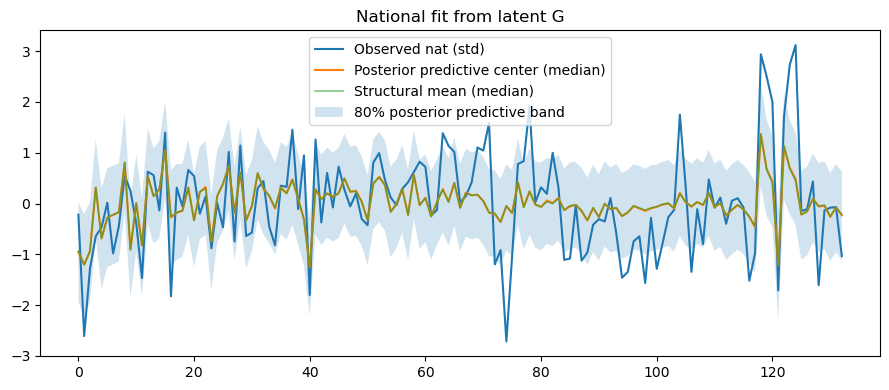

[Check] 80% PPC coverage = 0.759  (target ~0.75–0.85)
[Check] corr(center, obs) = 0.677     (target ≥ 0.70)
[Check] RMSE (std units)   = 0.792
[Check] b_nat_tilde 90% CI = [0.125, 0.263]  (should be > 0)  | median=0.187
[Check] spectral radius  median=0.969  p95=0.970  % near guard (≥0.97-1e-3)=60.7%


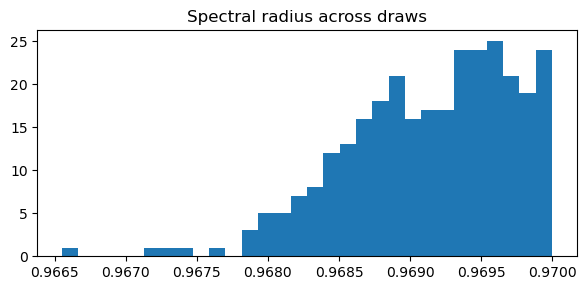

[Check] exp(h): median=1.391, p05=0.551, p95=6.177  (should move, not pinned)


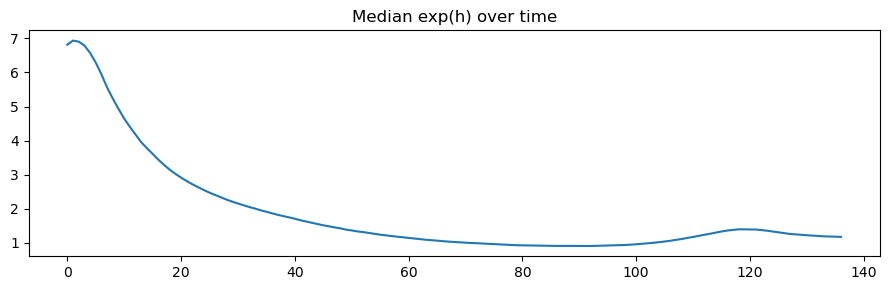

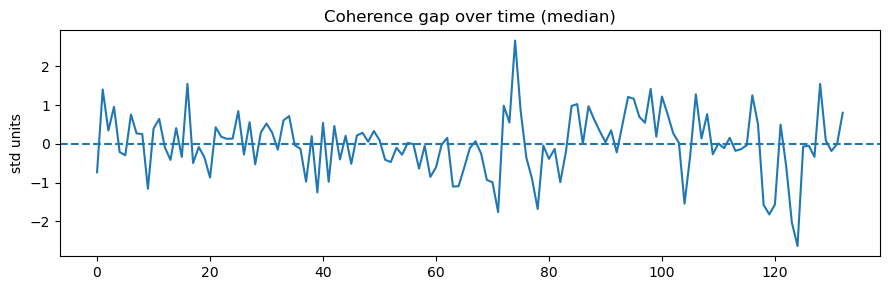

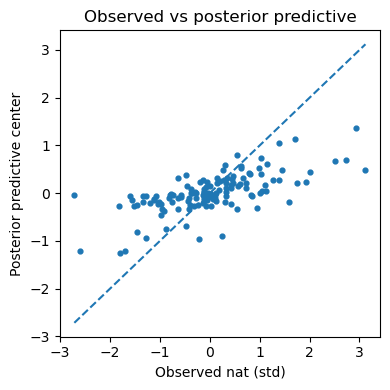

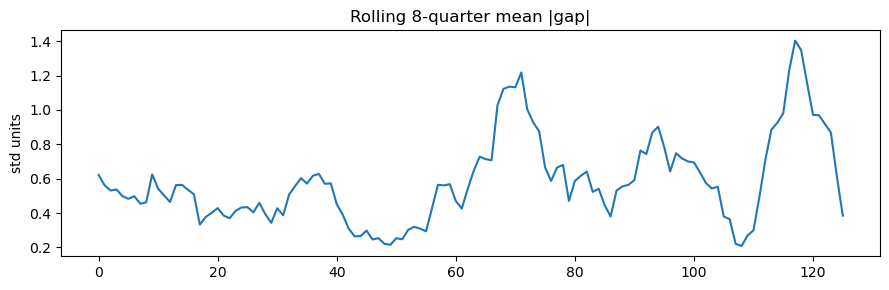

In [55]:
# Verification block (latent-G based, PPC-corrected)
import numpy as np, matplotlib.pyplot as plt

assert isinstance(keep_stab, list) and len(keep_stab) > 0, "need keep_stab=list of draw dicts"

# Collect draws
S = len(keep_stab)
G_draws         = np.stack([d["G"] for d in keep_stab], axis=0)                      # (S,T,n)
a_nat_draws     = np.array([d.get("a_nat") for d in keep_stab], dtype=float)         # (S,)
b_nat_draws     = np.array([d.get("b_nat") for d in keep_stab], dtype=float)         # (S,)
sigma_nat_draws = np.array([d.get("sigma_nat", np.nan) for d in keep_stab])          # (S,)

# Tilde params (ref-standardized national measurement)
a_nat_tilde_draws = np.array([d["a_nat_tilde"] for d in keep_stab], dtype=float)     # (S,)
b_nat_tilde_draws = np.array([d["b_nat_tilde"] for d in keep_stab], dtype=float)     # (S,)
WG_mu_ref_draws   = np.array([d.get("WG_mu_ref", d.get("WG_mean")) for d in keep_stab], dtype=float)  # (S,)
WG_sd_ref_draws   = np.array([d.get("WG_sd_ref", d.get("WG_sd"))   for d in keep_stab], dtype=float)  # (S,)

#  VAR coeffs & SV states
Phi_draws = None
if "Phi_list" in keep_stab[0]:
    Phi_draws = np.stack([np.stack(d["Phi_list"], axis=0) for d in keep_stab], axis=0)  # (S,p,n,n)

h_draws = None
if "h" in keep_stab[0]:
    h_draws = np.stack([d["h"] for d in keep_stab], axis=0)                               # (S,T,n)

T, n_states = G_draws.shape[1], G_draws.shape[2]

# Build national from latent G 
ok_nat = (np.isfinite(y_nat_obs_std) & np.isfinite(W_q).all(1) & (W_q.sum(1) > 0))
W_nat = W_q[ok_nat]                                                                      # (Tnat,n)
WG_draws = np.einsum("tn,stn->st", W_nat, G_draws[:, ok_nat, :])                         # (S,Tnat)

# Standardize WG per-draw using the saved reference mean/sd
WG_til_draws = (WG_draws - WG_mu_ref_draws[:, None]) / (WG_sd_ref_draws[:, None] + 1e-12)

# Structural (latent) mean of national in standardized space
nat_mean = a_nat_tilde_draws[:, None] + b_nat_tilde_draws[:, None] * WG_til_draws       # (S,Tnat)
struct_med = np.median(nat_mean, axis=0)                                                # (Tnat,)

y_nat_slice = y_nat_obs_std[ok_nat]                                                     # (Tnat,)

# posterior predictive
# If sigma_nat is saved, use it; otherwise fallback to per-draw residual sd
sigma_nat_finite = np.isfinite(sigma_nat_draws)
if sigma_nat_finite.any():
    sigmaB = np.repeat(sigma_nat_draws[:, None], nat_mean.shape[1], axis=1)             # (S,Tnat)
else:
    resid = y_nat_slice[None, :] - nat_mean
    sigmaB = resid.std(axis=1, ddof=1)[:, None].repeat(nat_mean.shape[1], axis=1)

rng = np.random.default_rng(123)
ppc = nat_mean + sigmaB * rng.standard_normal(nat_mean.shape)                            # (S,Tnat)
ppc_center = np.median(ppc, axis=0)                                                      # (Tnat,)
lo_ppc, hi_ppc = np.quantile(ppc, [0.10, 0.90], axis=0)

# Overlay plot 
t = np.arange(ppc_center.size)
plt.figure(figsize=(9, 4))
plt.plot(y_nat_slice, label="Observed nat (std)")
plt.plot(ppc_center, label="Posterior predictive center (median)")
plt.plot(struct_med, alpha=0.6, linewidth=1.2, label="Structural mean (median)")
plt.fill_between(t, lo_ppc, hi_ppc, alpha=0.2, label="80% posterior predictive band")
plt.title("National fit from latent G")
plt.legend(); plt.tight_layout(); plt.show()

#  Scores (against same PPC center) 
coverage80 = np.mean((y_nat_slice >= lo_ppc) & (y_nat_slice <= hi_ppc))
corr = np.corrcoef(ppc_center, y_nat_slice)[0, 1]
rmse = float(np.sqrt(np.mean((ppc_center - y_nat_slice) ** 2)))

print(f"[Check] 80% PPC coverage = {coverage80:.3f}  (target ~0.75–0.85)")
print(f"[Check] corr(center, obs) = {corr:.3f}     (target ≥ 0.70)")
print(f"[Check] RMSE (std units)   = {rmse:.3f}")

# Slope strength (tilde scale)
b_q05, b_q50, b_q95 = np.quantile(b_nat_tilde_draws, [0.05, 0.5, 0.95])
print(f"[Check] b_nat_tilde 90% CI = [{b_q05:.3f}, {b_q95:.3f}]  (should be > 0)  | median={b_q50:.3f}")

# VAR stability diagnostics
def spectral_radius_from_Phi(Phi):  # Phi: (p,n,n)
    p, n = Phi.shape[0], Phi.shape[1]
    A = np.zeros((n * p, n * p))
    A[:n, :n * p] = np.hstack([Phi[l] for l in range(p)])   # companion top block
    if p > 1:
        A[n:, :n * (p - 1)] = np.eye(n * (p - 1))
    ev = np.linalg.eigvals(A)
    return float(np.max(np.abs(ev)))

if Phi_draws is not None:
    idx = np.arange(min(S, 300))
    rhos = np.array([spectral_radius_from_Phi(Phi_draws[i]) for i in idx])
    print(f"[Check] spectral radius  median={np.median(rhos):.3f}  "
          f"p95={np.quantile(rhos,0.95):.3f}  "
          f"% near guard (≥0.97-1e-3)={np.mean(rhos>=0.969):.1%}")
    plt.figure(figsize=(6, 3)); plt.hist(rhos, bins=30)
    plt.title("Spectral radius across draws"); plt.tight_layout(); plt.show()
else:
    print("[Info] Phi_list not saved per draw; skip spectral-radius check.")

#  SV alive 
if h_draws is not None:
    vol = np.exp(h_draws)  # (S,T,n)
    vol_med = float(np.median(vol))
    vol_q05 = float(np.quantile(vol, 0.05))
    vol_q95 = float(np.quantile(vol, 0.95))
    print(f"[Check] exp(h): median={vol_med:.3f}, p05={vol_q05:.3f}, p95={vol_q95:.3f}  (should move, not pinned)")
    v_t_med = np.median(np.median(vol, axis=2), axis=0)  # median over draws & states by time
    plt.figure(figsize=(9, 3)); plt.plot(v_t_med); plt.title("Median exp(h) over time")
    plt.tight_layout(); plt.show()
else:
    print("[Info] h not saved; skip SV check.")

# Coherence visuals (use PPC center for consistency) 
gap = ppc_center - y_nat_slice
plt.figure(figsize=(9, 3))
plt.axhline(0, linestyle="--"); plt.plot(gap)
plt.title("Coherence gap over time (median)"); plt.ylabel("std units")
plt.tight_layout(); plt.show()

plt.figure(figsize=(4, 4))
mn, mx = np.min([y_nat_slice, ppc_center]), np.max([y_nat_slice, ppc_center])
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.scatter(y_nat_slice, ppc_center, s=12)
plt.xlabel("Observed nat (std)"); plt.ylabel("Posterior predictive center")
plt.title("Observed vs posterior predictive"); plt.tight_layout(); plt.show()

#  Rolling 8-quarter mean |gap|
if gap.size >= 8:
    w = np.ones(8) / 8.0
    roll_mean_abs_gap = np.convolve(np.abs(gap), w, mode="valid")
    plt.figure(figsize=(9, 3))
    plt.plot(roll_mean_abs_gap)
    plt.title("Rolling 8-quarter mean |gap|"); plt.ylabel("std units")
    plt.tight_layout(); plt.show()


In [57]:
# medians across draws
G_med = np.median(G_draws, axis=0)              # (T, n_states)
nat_obs = y_nat_obs_std[ok_nat]                  # observed nat (std)
Wnat    = W_q[ok_nat]                            # weights (Tnat, n_states)

# scale states so weighted sum == observed national
G_rec = G_med.copy()[ok_nat]                     # (Tnat, n_states)
for t in range(G_rec.shape[0]):
    den = float(Wnat[t] @ G_rec[t])
    s   = nat_obs[t] / den if abs(den) > 1e-12 else 1.0
    G_rec[t] *= s
# G_rec is reconciled states (std units); Wnat @ G_rec[t] == nat_obs[t]


[Audit] Coherence max|diff|: 4.440892098500626e-15

=== State-level test window (last 8Q) ===
Median RMSE (model): 0.36374760670085965
Share states meeting corr ≥ 0.70: 0.875
Share states with 80% coverage in [0.75,0.85]: 0.0
Share states beating baselines (RMSE): Naive=1.00, AR1=0.75, TSLM=0.75


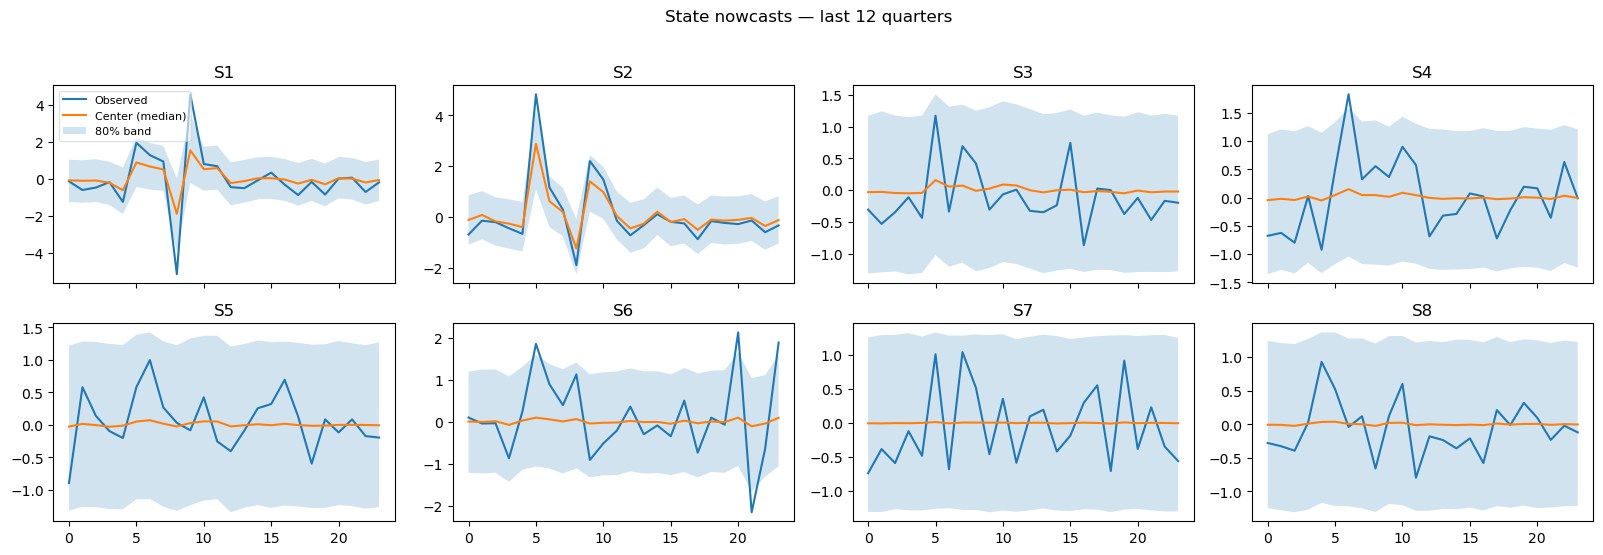

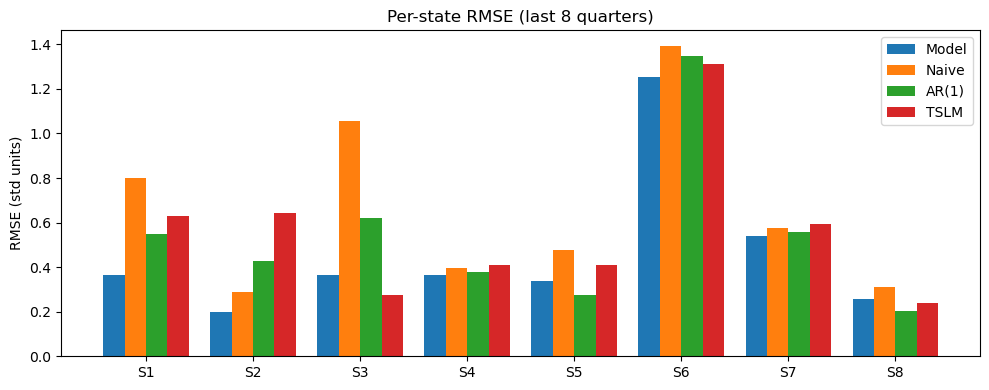

In [59]:

# State Evaluation and Overview

rng = np.random.default_rng(123)

# Helpers
def first_present(ns, names):
    """Return the first variable that exists in caller globals() by name."""
    g = globals()
    for nm in names:
        if nm in g and g[nm] is not None:
            return g[nm]
    raise NameError(f"None of {names} found in globals().")

def pull_vec_draws(keep_stab, key_opts, n_states, default):
    """Return array (S, n_states) by pulling a vector from each draw, else default."""
    S = len(keep_stab)
    out = np.empty((S, n_states), float)
    found_any = False
    for s, d in enumerate(keep_stab):
        v = None
        for k in key_opts:
            if k in d and d[k] is not None:
                v = np.asarray(d[k], float)
                break
        if v is None:
            v = np.full(n_states, default, float)
        else:
            found_any = True
            # allow scalar or length-n vector
            if v.ndim == 0:
                v = np.full(n_states, float(v))
            elif v.size != n_states:
                raise ValueError(f"{key_opts} size mismatch: got {v.size}, expected {n_states}")
        out[s] = v
    return out, found_any

def rmse(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    if not np.any(m): return np.nan
    return float(np.sqrt(np.mean((a[m] - b[m])**2)))

def corr(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    if np.sum(m) < 3: return np.nan
    return float(np.corrcoef(a[m], b[m])[0,1])

# Pull  objects 
assert isinstance(keep_stab, list) and len(keep_stab)>0, "need keep_stab=list of draw dicts"

# latent states
G_draws = np.stack([d["G"] for d in keep_stab], axis=0)  # (S,T,n)
S, T, n = G_draws.shape

# observations: states (std)
y_states = first_present(globals(), ["y_state_obs_std","y_sfd_obs_std","y_states_obs_std"])
y_states = np.asarray(y_states, float)                    # (T,n)

# national obs (std) + weights
y_nat_obs_std = first_present(globals(), ["y_nat_obs_std"])
W_q = first_present(globals(), ["W_q"])                  # (T, n) with row sums >0 when nat is observed

# Try to get per-state a,b,sigma (fallbacks if absent)
a_draws, have_a = pull_vec_draws(keep_stab, ["a_sfd","a_state","a_states"], n_states=n, default=0.0)   # (S,n)
b_draws, have_b = pull_vec_draws(keep_stab, ["b_sfd","b_state","b_states"], n_states=n, default=1.0)   # (S,n)
sig_draws_raw, have_sig = pull_vec_draws(keep_stab, ["sigma_sfd","sigma_state","sigma_states"], n_states=n, default=np.nan)

#  Posterior centers & PPC for STATES 
# structural mean per draw/time/state: a + b * G
mu = a_draws[:,None,:] + b_draws[:,None,:] * G_draws     # (S,T,n)

# center & 80% structural band
center = np.median(mu, axis=0)                           # (T,n)
lo_str, hi_str = np.quantile(mu, [0.10, 0.90], axis=0)   # (T,n)

# build sigma per-draw per-state; if missing, infer per draw from residuals
sigma = sig_draws_raw.copy()                              # (S,n)
if not have_sig:
    sigma = np.empty_like(sig_draws_raw)
    for s in range(S):
        resid = y_states - mu[s]
        # per-state robust sd over all t
        sigma[s] = np.nanstd(resid, axis=0, ddof=1)
sigma = np.where(np.isfinite(sigma), sigma, np.nanmedian(sigma, axis=0, keepdims=True))

# simulate PPC for 80% bands
eps = rng.standard_normal(size=(S,T,n))
ppc = mu + sigma[:,None,:] * eps                          # (S,T,n)
lo_ppc, hi_ppc = np.quantile(ppc, [0.10, 0.90], axis=0)   # (T,n)

# coverage per state (full sample where obs exists)
m_obs = np.isfinite(y_states)
cov80_state = np.nanmean((y_states >= lo_ppc) & (y_states <= hi_ppc) & m_obs, axis=0)   # (n,)

#  Last-8-quarter test metrics 
h_test = 8
tr_end = T - h_test
y_tr, y_te = y_states[:tr_end], y_states[tr_end:]
c_tr, c_te = center[:tr_end], center[tr_end:]
lo_te, hi_te = lo_ppc[tr_end:], hi_ppc[tr_end:]

rmse_model = np.array([rmse(y_te[:,j], c_te[:,j]) for j in range(n)])
corr_model = np.array([corr(y_te[:,j], c_te[:,j]) for j in range(n)])
cov80_te   = np.array([np.nanmean((y_te[:,j] >= lo_te[:,j]) & (y_te[:,j] <= hi_te[:,j])) for j in range(n)])

#  Baselines: Naive, AR(1), TSLM(trend + quarterly dummies) 
def forecast_naive(y, h):
    y = y.copy()
    if np.any(~np.isfinite(y)):  # simple forward-fill for missing
        idx = np.where(np.isfinite(y))[0]
        if len(idx)==0: return np.full(h, np.nan)
        for t in range(idx[0]+1, len(y)):
            if not np.isfinite(y[t]): y[t] = y[t-1]
    # RW forecast = last observed repeated
    return np.repeat(y[-1], h)

def forecast_ar1(y, h):
    m = np.isfinite(y[1:]) & np.isfinite(y[:-1])
    if np.sum(m) < 3:
        return forecast_naive(y, h)
    x, z = y[:-1][m], y[1:][m]
    phi = float(np.dot(x, z) / np.dot(x, x)) if np.dot(x,x)>0 else 0.0
    f = np.empty(h, float)
    f[0] = y[-1] if np.isfinite(y[-1]) else np.nanmedian(y)
    for k in range(1, h):
        f[k] = phi * f[k-1]
    return f

def forecast_tslm(y, h, t0=0):
    # y_t = α + β*t + γ_q + e_t with quarterly dummies (Q2/Q3/Q4)
    T = len(y); t = np.arange(t0, t0+T)
    q = (np.arange(T) % 4)
    X = np.column_stack([
        np.ones(T),
        t,
        (q==1).astype(float),
        (q==2).astype(float),
        (q==3).astype(float),
    ])
    m = np.isfinite(y)
    if np.sum(m) < 6:
        return forecast_naive(y, h)
    beta, *_ = np.linalg.lstsq(X[m], y[m], rcond=None)
    # future design
    tf = np.arange(t0+T, t0+T+h)
    qf = (np.arange(T, T+h) % 4)
    Xf = np.column_stack([
        np.ones(h),
        tf,
        (qf==1).astype(float),
        (qf==2).astype(float),
        (qf==3).astype(float),
    ])
    return Xf @ beta

rmse_naive = np.zeros(n); rmse_ar1 = np.zeros(n); rmse_tslm = np.zeros(n)
for j in range(n):
    yj = y_states[:,j]
    f_naive = forecast_naive(yj[:tr_end], h_test)
    f_ar1   = forecast_ar1(yj[:tr_end], h_test)
    f_tslm  = forecast_tslm(yj[:tr_end], h_test)
    rmse_naive[j] = rmse(y_te[:,j], f_naive)
    rmse_ar1[j]   = rmse(y_te[:,j], f_ar1)
    rmse_tslm[j]  = rmse(y_te[:,j], f_tslm)

# Simple per-time reconciliation (scaler) 
ok_nat = (np.isfinite(y_nat_obs_std) & np.isfinite(W_q).all(1) & (W_q.sum(1) > 0))
Wnat = W_q[ok_nat]                        # (Tnat, n)
nat_obs = y_nat_obs_std[ok_nat]           # (Tnat,)

center_states = center[ok_nat]            # (Tnat, n)
den = (Wnat * center_states).sum(1)       # (Tnat,)
scale = np.where(np.abs(den)>1e-12, nat_obs/den, 1.0)
states_rec = center_states * scale[:,None]  # reconciled centers

# coherence audit table
coh_sum = (Wnat * states_rec).sum(1)
coh_df = pd.DataFrame({
    "t_idx": np.arange(len(nat_obs)),
    "nat_obs": nat_obs,
    "W_state_rec": coh_sum,
    "diff": coh_sum - nat_obs
})
print("[Audit] Coherence max|diff|:", float(np.max(np.abs(coh_df["diff"]))))

#  Acceptance summary 
accept_corr   = np.nanmean(corr_model >= 0.70)
accept_cov    = np.nanmean((cov80_te >= 0.75) & (cov80_te <= 0.85))
beat_naive    = np.nanmean(rmse_model < rmse_naive)
beat_ar1      = np.nanmean(rmse_model < rmse_ar1)
beat_tslm     = np.nanmean(rmse_model < rmse_tslm)

print("\n=== State-level test window (last 8Q) ===")
print("Median RMSE (model):", float(np.nanmedian(rmse_model)))
print("Share states meeting corr ≥ 0.70:", float(accept_corr))
print("Share states with 80% coverage in [0.75,0.85]:", float(accept_cov))
print("Share states beating baselines (RMSE): Naive={:.2f}, AR1={:.2f}, TSLM={:.2f}".format(
    beat_naive, beat_ar1, beat_tslm
))

#  Fig 1: Faceted state nowcasts (last 12Q) 
last_L = 24
idx0 = max(0, T - last_L)
state_names = first_present(globals(), ["state_names","state_codes","states_list"]) if "state_names" in globals() or "state_codes" in globals() or "states_list" in globals() else [f"S{j+1}" for j in range(n)]

ncols = 4
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.7*nrows), sharex=True, sharey=False)
axes = np.array(axes).reshape(-1)
for j in range(n):
    ax = axes[j]
    ax.plot(y_states[idx0:, j], lw=1.5, label="Observed")
    ax.plot(center[idx0:, j], lw=1.5, label="Center (median)")
    ax.fill_between(np.arange(T-idx0), lo_ppc[idx0:, j], hi_ppc[idx0:, j], alpha=0.2, label="80% band")
    ax.set_title(state_names[j])
for k in range(n, len(axes)): axes[k].axis("off")
axes[0].legend(loc="upper left", fontsize=8, framealpha=0.6)
fig.suptitle("State nowcasts — last 12 quarters", y=1.02)
plt.tight_layout(); plt.show()

#  Fig 2: RMSE by state (model vs baselines, last 8Q)
X = np.arange(n)
width = 0.20
plt.figure(figsize=(max(10, n*1.2), 4))
plt.bar(X - 1.5*width, rmse_model, width, label="Model")
plt.bar(X - 0.5*width, rmse_naive, width, label="Naive")
plt.bar(X + 0.5*width, rmse_ar1,   width, label="AR(1)")
plt.bar(X + 1.5*width, rmse_tslm,  width, label="TSLM")
plt.xticks(X, state_names, rotation=0)
plt.ylabel("RMSE (std units)")
plt.title("Per-state RMSE (last 8 quarters)")
plt.legend(); plt.tight_layout(); plt.show()

